In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras.optimizers import RMSprop
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Model in Keras

In [31]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 256
TRAIN_IMG_SIZE_WIDTH = 1600

BATCH_SIZE = 4

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 1


In [11]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V3_4(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, 
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,(int(self.df['ClassId'].iloc[indexes[idx]]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        
        X_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        
        (X_list, y_list) = zip(image_generator, mask_generator).__next__()
        for i in range(len(X_list)):
            X_arg[i,] = X[i,]
            y_arg[i,:,:,:] = y[i,:,:,:]
            X_arg[i + self.batch_size] = X_list[i]
            y_arg[i + self.batch_size] = y_list[i]

        return X_arg, y_arg

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [13]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_256x1600_segmentation_model(input_shape=(256, 1600, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    down_2 = Conv2D(8, (3, 3), padding='same')(inputs)
    down_2 = BatchNormalization()(down_2)
    down_2 = Activation('relu')(down_2)
    down_2 = Conv2D(8, (3, 3), padding='same')(down_2)
    down_2 = BatchNormalization()(down_2)
    down_2 = Activation('relu')(down_2)
    down_2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_2)

    down_1 = Conv2D(16, (3, 3), padding='same')(down_2_pool)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1 = Conv2D(16, (3, 3), padding='same')(down_1)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_1)
    
    down0 = Conv2D(32, (3, 3), padding='same')(down_1_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4)

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) 

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)

    up_1 = UpSampling2D((2, 2))(up0)
    up_1 = concatenate([down_1, up_1], axis=3)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(16, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)

    up_2 = UpSampling2D((2, 2))(up_1)
    up_2 = concatenate([down_2, up_2], axis=3)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)
    up_2 = Conv2D(8, (3, 3), padding='same')(up_2)
    up_2 = BatchNormalization()(up_2)
    up_2 = Activation('relu')(up_2)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up_2)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [14]:
advanced_model = advanced_unet_256x1600_segmentation_model(num_classes=4)
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 1600, 8) 32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 1600, 8) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 8, 50, 256)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 50, 256)   590080      activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 8, 50, 256)   1024        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 8, 50, 256)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 4, 25, 256)   0           activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 

up_sampling2d_3 (UpSampling2D)  (None, 16, 100, 256) 0           activation_22[0][0]              
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 16, 100, 384) 0           activation_10[0][0]              
                                                                 up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 16, 100, 128) 442496      concatenate_3[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 100, 128) 512         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 100, 128) 0           batch_normalization_23[0][0]     
__________

batch_normalization_33 (BatchNo (None, 128, 800, 16) 64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 128, 800, 16) 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 800, 16) 2320        activation_33[0][0]              
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 800, 16) 64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 800, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
up_samplin

In [23]:
layer = advanced_model.get_layer(index=109)
print(layer.get_config())

{'name': 'batch_normalization_31', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}


In [17]:
# This layer has 3x3x16x16 = 2320 params (weights) 
layer = advanced_model.get_layer(index=11)
layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

[-0.1164664   0.09346746 -0.00426714 -0.09404384  0.1425933  -0.14255296
  0.01436068  0.08169857 -0.02896807  0.06693725 -0.05650454 -0.0236631
  0.07360651 -0.05841386  0.02960557  0.07286337]


In [18]:
# This layer has 1x16 = 16 params (weights) 
print(len(layer.get_weights()[1]))

# Combined this model has 2304 + 16 params = 2320 params (weights) as illustrated above for index 11

16


In [19]:
model_128x800 = load_model('./models/unet_model_128x800_unsharp_4classes_v1.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

Instructions for updating:
Use tf.cast instead.


In [20]:
model_128x800.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 800, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 800, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4, 25, 512)   2048        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 4, 25, 512)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 2, 25, 512)   0           activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 2, 25, 1024)  4719616     max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 2, 25, 1024)  4096        conv2d_13[0][0]                  
__________

conv2d_23 (Conv2D)              (None, 16, 100, 128) 147584      activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 100, 128) 512         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 100, 128) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 32, 200, 128) 0           activation_23[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32, 200, 192) 0           activation_6[0][0]               
                                                                 up_sampling2d_4[0][0]            
__________

In [24]:
layer_128x800 = model_128x800.get_layer(index=102)
print(layer_128x800.get_config())

{'name': 'batch_normalization_29', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}


#### Moving weights from low res. sub-model to higher res. including model

We are now going to marry up layers with index 11 to 102 for the advanced_model with the pre-trained weights for the 64x400 model whose indexes are 4 to 95

In [25]:
# Takes roughly a minute
for idx in range(4, 103):
    layer_128x800 = model_128x800.get_layer(index=idx)
    layer_256x1600 = advanced_model.get_layer(index=(idx + 7))
    layer_256x1600.set_weights(layer_128x800.get_weights())  
    layer_256x1600.trainable=False

In [26]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [28]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.19774145  0.0426113   0.00757337 -0.06391622  0.10728361  0.08970336
  0.09039313 -0.1798031   0.07129601  0.01274211 -0.15537432  0.01191017
 -0.18142171 -0.13882028  0.03663984 -0.03118151]


#### Back to training

In [29]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./unet_model_256x1600_unsharp_4classes_v1.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [32]:
# 1 EPOCH: dice_coeff: 0.2255 - acc: 0.0521 - val_loss: -0.8723 - val_dice_coeff: 0.4503 - val_acc: 0.0488

idx = int(0.8*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/1


 131/1419 [=>............................] - ETA: 1:23:42 - loss: 0.1938 - dice_coeff: 0.0341 - acc: 0.045 - ETA: 1:15:51 - loss: 0.2253 - dice_coeff: 0.0190 - acc: 0.036 - ETA: 1:13:17 - loss: 0.2087 - dice_coeff: 0.0255 - acc: 0.039 - ETA: 1:12:12 - loss: 0.2150 - dice_coeff: 0.0241 - acc: 0.033 - ETA: 1:11:24 - loss: 0.2073 - dice_coeff: 0.0274 - acc: 0.034 - ETA: 1:10:50 - loss: 0.1731 - dice_coeff: 0.0434 - acc: 0.054 - ETA: 1:10:28 - loss: 0.1757 - dice_coeff: 0.0414 - acc: 0.051 - ETA: 1:10:03 - loss: 0.1742 - dice_coeff: 0.0419 - acc: 0.052 - ETA: 1:09:45 - loss: 0.1655 - dice_coeff: 0.0458 - acc: 0.056 - ETA: 1:09:34 - loss: 0.1693 - dice_coeff: 0.0435 - acc: 0.053 - ETA: 1:09:17 - loss: 0.1658 - dice_coeff: 0.0446 - acc: 0.053 - ETA: 1:07:36 - loss: 0.1570 - dice_coeff: 0.0483 - acc: 0.056 - ETA: 1:06:07 - loss: 0.1533 - dice_coeff: 0.0493 - acc: 0.056 - ETA: 1:04:53 - loss: 0.1360 - dice_coeff: 0.0570 - acc: 0.063 - ETA: 1:03:45 - loss: 0.1322 - dice_coeff: 0.0585 - acc: 0.0

 263/1419 [====>.........................] - ETA: 48:01 - loss: 0.1048 - dice_coeff: 0.0583 - acc: 0.048 - ETA: 47:57 - loss: 0.1053 - dice_coeff: 0.0580 - acc: 0.048 - ETA: 47:55 - loss: 0.1060 - dice_coeff: 0.0576 - acc: 0.047 - ETA: 47:53 - loss: 0.1061 - dice_coeff: 0.0574 - acc: 0.047 - ETA: 47:50 - loss: 0.1045 - dice_coeff: 0.0581 - acc: 0.048 - ETA: 47:46 - loss: 0.1050 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:44 - loss: 0.1049 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:41 - loss: 0.1047 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:38 - loss: 0.1044 - dice_coeff: 0.0578 - acc: 0.047 - ETA: 47:35 - loss: 0.1046 - dice_coeff: 0.0576 - acc: 0.047 - ETA: 47:34 - loss: 0.1049 - dice_coeff: 0.0574 - acc: 0.047 - ETA: 47:31 - loss: 0.1049 - dice_coeff: 0.0573 - acc: 0.047 - ETA: 47:29 - loss: 0.1054 - dice_coeff: 0.0570 - acc: 0.047 - ETA: 47:26 - loss: 0.1049 - dice_coeff: 0.0572 - acc: 0.047 - ETA: 47:24 - loss: 0.1052 - dice_coeff: 0.0570 - acc: 0.046 - ETA: 47:21 - loss: 0.1048

 395/1419 [=======>......................] - ETA: 42:39 - loss: 0.0825 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:37 - loss: 0.0821 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:35 - loss: 0.0823 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:32 - loss: 0.0821 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:30 - loss: 0.0823 - dice_coeff: 0.0601 - acc: 0.045 - ETA: 42:27 - loss: 0.0823 - dice_coeff: 0.0600 - acc: 0.045 - ETA: 42:24 - loss: 0.0812 - dice_coeff: 0.0605 - acc: 0.045 - ETA: 42:22 - loss: 0.0813 - dice_coeff: 0.0604 - acc: 0.045 - ETA: 42:19 - loss: 0.0814 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:17 - loss: 0.0812 - dice_coeff: 0.0602 - acc: 0.045 - ETA: 42:15 - loss: 0.0807 - dice_coeff: 0.0604 - acc: 0.045 - ETA: 42:13 - loss: 0.0808 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:10 - loss: 0.0808 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:08 - loss: 0.0802 - dice_coeff: 0.0605 - acc: 0.045 - ETA: 42:05 - loss: 0.0804 - dice_coeff: 0.0603 - acc: 0.045 - ETA: 42:03 - loss: 0.0801

 527/1419 [==========>...................] - ETA: 37:31 - loss: 0.0543 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:28 - loss: 0.0542 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:26 - loss: 0.0541 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:24 - loss: 0.0541 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:22 - loss: 0.0541 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:20 - loss: 0.0540 - dice_coeff: 0.0663 - acc: 0.046 - ETA: 37:17 - loss: 0.0537 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:15 - loss: 0.0534 - dice_coeff: 0.0664 - acc: 0.046 - ETA: 37:14 - loss: 0.0532 - dice_coeff: 0.0665 - acc: 0.046 - ETA: 37:12 - loss: 0.0529 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:09 - loss: 0.0528 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:07 - loss: 0.0526 - dice_coeff: 0.0667 - acc: 0.046 - ETA: 37:05 - loss: 0.0524 - dice_coeff: 0.0667 - acc: 0.046 - ETA: 37:03 - loss: 0.0525 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 37:00 - loss: 0.0524 - dice_coeff: 0.0666 - acc: 0.046 - ETA: 36:58 - loss: 0.0523

 659/1419 [============>.................] - ETA: 32:35 - loss: 0.0346 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:32 - loss: 0.0346 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:30 - loss: 0.0347 - dice_coeff: 0.0691 - acc: 0.045 - ETA: 32:28 - loss: 0.0344 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:26 - loss: 0.0342 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:24 - loss: 0.0338 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:22 - loss: 0.0337 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:19 - loss: 0.0336 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:17 - loss: 0.0334 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:15 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:12 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:10 - loss: 0.0333 - dice_coeff: 0.0694 - acc: 0.045 - ETA: 32:08 - loss: 0.0333 - dice_coeff: 0.0693 - acc: 0.045 - ETA: 32:06 - loss: 0.0333 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:03 - loss: 0.0333 - dice_coeff: 0.0692 - acc: 0.045 - ETA: 32:01 - loss: 0.0327

 790/1419 [===============>..............] - ETA: 27:43 - loss: 0.0100 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:40 - loss: 0.0099 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:38 - loss: 0.0098 - dice_coeff: 0.0753 - acc: 0.046 - ETA: 27:36 - loss: 0.0100 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:34 - loss: 0.0100 - dice_coeff: 0.0751 - acc: 0.046 - ETA: 27:31 - loss: 0.0097 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:29 - loss: 0.0097 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:27 - loss: 0.0096 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:25 - loss: 0.0095 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:22 - loss: 0.0094 - dice_coeff: 0.0752 - acc: 0.046 - ETA: 27:20 - loss: 0.0094 - dice_coeff: 0.0752 - acc: 0.045 - ETA: 27:18 - loss: 0.0093 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:16 - loss: 0.0094 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:14 - loss: 0.0091 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:12 - loss: 0.0091 - dice_coeff: 0.0751 - acc: 0.045 - ETA: 27:09 - loss: 0.0090

 922/1419 [==================>...........] - ETA: 22:54 - loss: -0.0107 - dice_coeff: 0.0799 - acc: 0.04 - ETA: 22:52 - loss: -0.0111 - dice_coeff: 0.0801 - acc: 0.04 - ETA: 22:50 - loss: -0.0117 - dice_coeff: 0.0804 - acc: 0.04 - ETA: 22:47 - loss: -0.0121 - dice_coeff: 0.0805 - acc: 0.04 - ETA: 22:45 - loss: -0.0122 - dice_coeff: 0.0805 - acc: 0.04 - ETA: 22:43 - loss: -0.0124 - dice_coeff: 0.0806 - acc: 0.04 - ETA: 22:41 - loss: -0.0125 - dice_coeff: 0.0806 - acc: 0.04 - ETA: 22:39 - loss: -0.0131 - dice_coeff: 0.0808 - acc: 0.04 - ETA: 22:36 - loss: -0.0136 - dice_coeff: 0.0811 - acc: 0.04 - ETA: 22:34 - loss: -0.0142 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:32 - loss: -0.0142 - dice_coeff: 0.0812 - acc: 0.04 - ETA: 22:29 - loss: -0.0143 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:27 - loss: -0.0142 - dice_coeff: 0.0812 - acc: 0.04 - ETA: 22:25 - loss: -0.0145 - dice_coeff: 0.0813 - acc: 0.04 - ETA: 22:23 - loss: -0.0147 - dice_coeff: 0.0814 - acc: 0.04 - ETA: 22:21 - loss: -0.014

1054/1419 [=====================>........] - ETA: 18:06 - loss: -0.0400 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 18:04 - loss: -0.0401 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 18:01 - loss: -0.0402 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 17:59 - loss: -0.0403 - dice_coeff: 0.0895 - acc: 0.04 - ETA: 17:57 - loss: -0.0403 - dice_coeff: 0.0894 - acc: 0.04 - ETA: 17:55 - loss: -0.0408 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:53 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:50 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:48 - loss: -0.0409 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:46 - loss: -0.0410 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:44 - loss: -0.0414 - dice_coeff: 0.0898 - acc: 0.04 - ETA: 17:42 - loss: -0.0414 - dice_coeff: 0.0897 - acc: 0.04 - ETA: 17:39 - loss: -0.0414 - dice_coeff: 0.0897 - acc: 0.04 - ETA: 17:37 - loss: -0.0413 - dice_coeff: 0.0896 - acc: 0.04 - ETA: 17:35 - loss: -0.0418 - dice_coeff: 0.0898 - acc: 0.04 - ETA: 17:33 - loss: -0.041

1186/1419 [========================>.....] - ETA: 13:16 - loss: -0.0667 - dice_coeff: 0.0980 - acc: 0.04 - ETA: 13:13 - loss: -0.0670 - dice_coeff: 0.0982 - acc: 0.04 - ETA: 13:11 - loss: -0.0673 - dice_coeff: 0.0983 - acc: 0.04 - ETA: 13:09 - loss: -0.0679 - dice_coeff: 0.0985 - acc: 0.04 - ETA: 13:07 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:05 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:03 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 13:00 - loss: -0.0684 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:58 - loss: -0.0685 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:56 - loss: -0.0685 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:54 - loss: -0.0686 - dice_coeff: 0.0986 - acc: 0.04 - ETA: 12:52 - loss: -0.0686 - dice_coeff: 0.0986 - acc: 0.04 - ETA: 12:49 - loss: -0.0689 - dice_coeff: 0.0988 - acc: 0.04 - ETA: 12:47 - loss: -0.0690 - dice_coeff: 0.0987 - acc: 0.04 - ETA: 12:45 - loss: -0.0693 - dice_coeff: 0.0989 - acc: 0.04 - ETA: 12:43 - loss: -0.069

1318/1419 [==========================>...] - ETA: 8:26 - loss: -0.0901 - dice_coeff: 0.1055 - acc: 0.047 - ETA: 8:24 - loss: -0.0902 - dice_coeff: 0.1054 - acc: 0.047 - ETA: 8:22 - loss: -0.0905 - dice_coeff: 0.1056 - acc: 0.047 - ETA: 8:20 - loss: -0.0912 - dice_coeff: 0.1059 - acc: 0.047 - ETA: 8:18 - loss: -0.0915 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:15 - loss: -0.0916 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:13 - loss: -0.0917 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:11 - loss: -0.0916 - dice_coeff: 0.1060 - acc: 0.047 - ETA: 8:09 - loss: -0.0920 - dice_coeff: 0.1061 - acc: 0.047 - ETA: 8:07 - loss: -0.0921 - dice_coeff: 0.1061 - acc: 0.047 - ETA: 8:04 - loss: -0.0925 - dice_coeff: 0.1063 - acc: 0.047 - ETA: 8:02 - loss: -0.0929 - dice_coeff: 0.1065 - acc: 0.047 - ETA: 8:00 - loss: -0.0935 - dice_coeff: 0.1067 - acc: 0.047 - ETA: 7:58 - loss: -0.0934 - dice_coeff: 0.1067 - acc: 0.047 - ETA: 7:56 - loss: -0.0938 - dice_coeff: 0.1068 - acc: 0.047 - ETA: 7:54 - loss: -0.0939

1419/1419 [==============================] - ETA: 3:38 - loss: -0.1191 - dice_coeff: 0.1161 - acc: 0.047 - ETA: 3:36 - loss: -0.1196 - dice_coeff: 0.1163 - acc: 0.047 - ETA: 3:33 - loss: -0.1196 - dice_coeff: 0.1163 - acc: 0.047 - ETA: 3:31 - loss: -0.1201 - dice_coeff: 0.1165 - acc: 0.047 - ETA: 3:29 - loss: -0.1201 - dice_coeff: 0.1165 - acc: 0.047 - ETA: 3:27 - loss: -0.1205 - dice_coeff: 0.1167 - acc: 0.047 - ETA: 3:25 - loss: -0.1208 - dice_coeff: 0.1168 - acc: 0.047 - ETA: 3:22 - loss: -0.1213 - dice_coeff: 0.1170 - acc: 0.047 - ETA: 3:20 - loss: -0.1217 - dice_coeff: 0.1172 - acc: 0.047 - ETA: 3:18 - loss: -0.1223 - dice_coeff: 0.1175 - acc: 0.047 - ETA: 3:16 - loss: -0.1223 - dice_coeff: 0.1175 - acc: 0.047 - ETA: 3:14 - loss: -0.1228 - dice_coeff: 0.1177 - acc: 0.047 - ETA: 3:12 - loss: -0.1229 - dice_coeff: 0.1177 - acc: 0.047 - ETA: 3:09 - loss: -0.1231 - dice_coeff: 0.1178 - acc: 0.047 - ETA: 3:07 - loss: -0.1236 - dice_coeff: 0.1180 - acc: 0.047 - ETA: 3:05 - loss: -0.1236

### Visualise results

In [35]:
# loss: -1.0319 - dice_coeff: 0.5650 - acc: 0.9551
# val_loss: -0.9757 - val_dice_coeff: 0.5386 - val_acc: 0.9611

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
#plot_training(history)

In [33]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


 131/1419 [=>............................] - ETA: 2:01:32 - loss: -0.5820 - dice_coeff: 0.3060 - acc: 0.04 - ETA: 1:20:19 - loss: -0.6616 - dice_coeff: 0.3466 - acc: 0.05 - ETA: 1:17:52 - loss: -0.7446 - dice_coeff: 0.3902 - acc: 0.07 - ETA: 1:15:09 - loss: -0.6398 - dice_coeff: 0.3377 - acc: 0.06 - ETA: 1:09:50 - loss: -0.6838 - dice_coeff: 0.3589 - acc: 0.06 - ETA: 1:06:34 - loss: -0.7031 - dice_coeff: 0.3683 - acc: 0.06 - ETA: 1:04:30 - loss: -0.7285 - dice_coeff: 0.3813 - acc: 0.07 - ETA: 1:02:41 - loss: -0.6606 - dice_coeff: 0.3499 - acc: 0.07 - ETA: 1:01:23 - loss: -0.6503 - dice_coeff: 0.3443 - acc: 0.06 - ETA: 1:00:15 - loss: -0.6427 - dice_coeff: 0.3409 - acc: 0.07 - ETA: 59:43 - loss: -0.6609 - dice_coeff: 0.3510 - acc: 0.0826 - ETA: 59:19 - loss: -0.6268 - dice_coeff: 0.3336 - acc: 0.07 - ETA: 58:39 - loss: -0.6184 - dice_coeff: 0.3288 - acc: 0.07 - ETA: 57:53 - loss: -0.5831 - dice_coeff: 0.3111 - acc: 0.06 - ETA: 57:20 - loss: -0.6076 - dice_coeff: 0.3230 - acc: 0.07 - ETA

 263/1419 [====>.........................] - ETA: 47:17 - loss: -0.5653 - dice_coeff: 0.2993 - acc: 0.05 - ETA: 47:15 - loss: -0.5642 - dice_coeff: 0.2987 - acc: 0.05 - ETA: 47:13 - loss: -0.5641 - dice_coeff: 0.2987 - acc: 0.05 - ETA: 47:10 - loss: -0.5649 - dice_coeff: 0.2990 - acc: 0.05 - ETA: 47:08 - loss: -0.5649 - dice_coeff: 0.2992 - acc: 0.05 - ETA: 47:06 - loss: -0.5649 - dice_coeff: 0.2992 - acc: 0.05 - ETA: 47:04 - loss: -0.5632 - dice_coeff: 0.2983 - acc: 0.05 - ETA: 47:02 - loss: -0.5613 - dice_coeff: 0.2973 - acc: 0.05 - ETA: 46:59 - loss: -0.5587 - dice_coeff: 0.2960 - acc: 0.05 - ETA: 46:57 - loss: -0.5571 - dice_coeff: 0.2951 - acc: 0.05 - ETA: 46:54 - loss: -0.5563 - dice_coeff: 0.2947 - acc: 0.05 - ETA: 46:51 - loss: -0.5544 - dice_coeff: 0.2937 - acc: 0.05 - ETA: 46:49 - loss: -0.5539 - dice_coeff: 0.2935 - acc: 0.05 - ETA: 46:47 - loss: -0.5511 - dice_coeff: 0.2921 - acc: 0.05 - ETA: 46:44 - loss: -0.5556 - dice_coeff: 0.2942 - acc: 0.05 - ETA: 46:41 - loss: -0.555

 395/1419 [=======>......................] - ETA: 42:07 - loss: -0.6067 - dice_coeff: 0.3188 - acc: 0.05 - ETA: 42:04 - loss: -0.6072 - dice_coeff: 0.3190 - acc: 0.05 - ETA: 42:02 - loss: -0.6073 - dice_coeff: 0.3191 - acc: 0.05 - ETA: 42:00 - loss: -0.6071 - dice_coeff: 0.3190 - acc: 0.05 - ETA: 41:58 - loss: -0.6057 - dice_coeff: 0.3183 - acc: 0.05 - ETA: 41:55 - loss: -0.6063 - dice_coeff: 0.3186 - acc: 0.05 - ETA: 41:53 - loss: -0.6061 - dice_coeff: 0.3185 - acc: 0.05 - ETA: 41:51 - loss: -0.6079 - dice_coeff: 0.3194 - acc: 0.05 - ETA: 41:49 - loss: -0.6077 - dice_coeff: 0.3193 - acc: 0.05 - ETA: 41:46 - loss: -0.6073 - dice_coeff: 0.3191 - acc: 0.05 - ETA: 41:44 - loss: -0.6083 - dice_coeff: 0.3196 - acc: 0.05 - ETA: 41:42 - loss: -0.6088 - dice_coeff: 0.3198 - acc: 0.05 - ETA: 41:40 - loss: -0.6075 - dice_coeff: 0.3192 - acc: 0.05 - ETA: 41:38 - loss: -0.6099 - dice_coeff: 0.3204 - acc: 0.05 - ETA: 41:36 - loss: -0.6100 - dice_coeff: 0.3205 - acc: 0.05 - ETA: 41:34 - loss: -0.608

 527/1419 [==========>...................] - ETA: 37:15 - loss: -0.6461 - dice_coeff: 0.3380 - acc: 0.05 - ETA: 37:13 - loss: -0.6476 - dice_coeff: 0.3387 - acc: 0.05 - ETA: 37:10 - loss: -0.6482 - dice_coeff: 0.3390 - acc: 0.05 - ETA: 37:08 - loss: -0.6475 - dice_coeff: 0.3386 - acc: 0.05 - ETA: 37:06 - loss: -0.6473 - dice_coeff: 0.3385 - acc: 0.05 - ETA: 37:04 - loss: -0.6469 - dice_coeff: 0.3383 - acc: 0.05 - ETA: 37:02 - loss: -0.6473 - dice_coeff: 0.3385 - acc: 0.05 - ETA: 37:00 - loss: -0.6489 - dice_coeff: 0.3393 - acc: 0.05 - ETA: 36:57 - loss: -0.6504 - dice_coeff: 0.3401 - acc: 0.05 - ETA: 36:55 - loss: -0.6496 - dice_coeff: 0.3396 - acc: 0.05 - ETA: 36:53 - loss: -0.6492 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:51 - loss: -0.6492 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:48 - loss: -0.6487 - dice_coeff: 0.3392 - acc: 0.05 - ETA: 36:46 - loss: -0.6493 - dice_coeff: 0.3395 - acc: 0.05 - ETA: 36:44 - loss: -0.6491 - dice_coeff: 0.3394 - acc: 0.05 - ETA: 36:42 - loss: -0.650

 659/1419 [============>.................] - ETA: 32:28 - loss: -0.6696 - dice_coeff: 0.3492 - acc: 0.05 - ETA: 32:25 - loss: -0.6700 - dice_coeff: 0.3494 - acc: 0.05 - ETA: 32:23 - loss: -0.6703 - dice_coeff: 0.3495 - acc: 0.05 - ETA: 32:21 - loss: -0.6710 - dice_coeff: 0.3498 - acc: 0.05 - ETA: 32:19 - loss: -0.6713 - dice_coeff: 0.3500 - acc: 0.05 - ETA: 32:17 - loss: -0.6723 - dice_coeff: 0.3505 - acc: 0.05 - ETA: 32:16 - loss: -0.6730 - dice_coeff: 0.3508 - acc: 0.05 - ETA: 32:14 - loss: -0.6731 - dice_coeff: 0.3509 - acc: 0.05 - ETA: 32:11 - loss: -0.6733 - dice_coeff: 0.3510 - acc: 0.05 - ETA: 32:09 - loss: -0.6736 - dice_coeff: 0.3511 - acc: 0.05 - ETA: 32:07 - loss: -0.6745 - dice_coeff: 0.3516 - acc: 0.05 - ETA: 32:04 - loss: -0.6742 - dice_coeff: 0.3514 - acc: 0.05 - ETA: 32:02 - loss: -0.6746 - dice_coeff: 0.3516 - acc: 0.05 - ETA: 32:00 - loss: -0.6754 - dice_coeff: 0.3520 - acc: 0.05 - ETA: 31:58 - loss: -0.6761 - dice_coeff: 0.3523 - acc: 0.05 - ETA: 31:56 - loss: -0.676

 791/1419 [===============>..............] - ETA: 27:43 - loss: -0.7129 - dice_coeff: 0.3702 - acc: 0.05 - ETA: 27:41 - loss: -0.7137 - dice_coeff: 0.3706 - acc: 0.05 - ETA: 27:38 - loss: -0.7142 - dice_coeff: 0.3709 - acc: 0.05 - ETA: 27:36 - loss: -0.7135 - dice_coeff: 0.3705 - acc: 0.05 - ETA: 27:34 - loss: -0.7133 - dice_coeff: 0.3704 - acc: 0.05 - ETA: 27:32 - loss: -0.7139 - dice_coeff: 0.3707 - acc: 0.05 - ETA: 27:30 - loss: -0.7146 - dice_coeff: 0.3710 - acc: 0.05 - ETA: 27:28 - loss: -0.7156 - dice_coeff: 0.3715 - acc: 0.05 - ETA: 27:26 - loss: -0.7159 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:23 - loss: -0.7159 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:21 - loss: -0.7160 - dice_coeff: 0.3717 - acc: 0.05 - ETA: 27:19 - loss: -0.7165 - dice_coeff: 0.3720 - acc: 0.05 - ETA: 27:17 - loss: -0.7169 - dice_coeff: 0.3722 - acc: 0.05 - ETA: 27:15 - loss: -0.7173 - dice_coeff: 0.3724 - acc: 0.05 - ETA: 27:12 - loss: -0.7168 - dice_coeff: 0.3721 - acc: 0.05 - ETA: 27:10 - loss: -0.716

 923/1419 [==================>...........] - ETA: 22:54 - loss: -0.7410 - dice_coeff: 0.3839 - acc: 0.05 - ETA: 22:52 - loss: -0.7416 - dice_coeff: 0.3842 - acc: 0.05 - ETA: 22:50 - loss: -0.7419 - dice_coeff: 0.3844 - acc: 0.05 - ETA: 22:48 - loss: -0.7425 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:46 - loss: -0.7423 - dice_coeff: 0.3846 - acc: 0.05 - ETA: 22:43 - loss: -0.7419 - dice_coeff: 0.3844 - acc: 0.05 - ETA: 22:41 - loss: -0.7427 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:39 - loss: -0.7425 - dice_coeff: 0.3847 - acc: 0.05 - ETA: 22:37 - loss: -0.7427 - dice_coeff: 0.3848 - acc: 0.05 - ETA: 22:35 - loss: -0.7430 - dice_coeff: 0.3849 - acc: 0.05 - ETA: 22:32 - loss: -0.7436 - dice_coeff: 0.3852 - acc: 0.05 - ETA: 22:30 - loss: -0.7442 - dice_coeff: 0.3855 - acc: 0.05 - ETA: 22:28 - loss: -0.7442 - dice_coeff: 0.3855 - acc: 0.05 - ETA: 22:26 - loss: -0.7446 - dice_coeff: 0.3857 - acc: 0.05 - ETA: 22:24 - loss: -0.7447 - dice_coeff: 0.3857 - acc: 0.05 - ETA: 22:22 - loss: -0.745

1055/1419 [=====================>........] - ETA: 18:05 - loss: -0.7650 - dice_coeff: 0.3958 - acc: 0.05 - ETA: 18:03 - loss: -0.7655 - dice_coeff: 0.3960 - acc: 0.05 - ETA: 18:01 - loss: -0.7662 - dice_coeff: 0.3964 - acc: 0.05 - ETA: 17:58 - loss: -0.7662 - dice_coeff: 0.3964 - acc: 0.05 - ETA: 17:56 - loss: -0.7658 - dice_coeff: 0.3962 - acc: 0.05 - ETA: 17:54 - loss: -0.7663 - dice_coeff: 0.3965 - acc: 0.05 - ETA: 17:52 - loss: -0.7667 - dice_coeff: 0.3967 - acc: 0.05 - ETA: 17:50 - loss: -0.7669 - dice_coeff: 0.3967 - acc: 0.05 - ETA: 17:47 - loss: -0.7671 - dice_coeff: 0.3968 - acc: 0.05 - ETA: 17:45 - loss: -0.7666 - dice_coeff: 0.3966 - acc: 0.05 - ETA: 17:43 - loss: -0.7672 - dice_coeff: 0.3969 - acc: 0.05 - ETA: 17:41 - loss: -0.7677 - dice_coeff: 0.3971 - acc: 0.05 - ETA: 17:39 - loss: -0.7684 - dice_coeff: 0.3975 - acc: 0.05 - ETA: 17:36 - loss: -0.7688 - dice_coeff: 0.3977 - acc: 0.05 - ETA: 17:34 - loss: -0.7690 - dice_coeff: 0.3978 - acc: 0.05 - ETA: 17:32 - loss: -0.769

1187/1419 [========================>.....] - ETA: 13:15 - loss: -0.7921 - dice_coeff: 0.4094 - acc: 0.05 - ETA: 13:13 - loss: -0.7922 - dice_coeff: 0.4094 - acc: 0.05 - ETA: 13:11 - loss: -0.7928 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:08 - loss: -0.7927 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:06 - loss: -0.7926 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 13:04 - loss: -0.7924 - dice_coeff: 0.4095 - acc: 0.05 - ETA: 13:02 - loss: -0.7926 - dice_coeff: 0.4096 - acc: 0.05 - ETA: 13:00 - loss: -0.7927 - dice_coeff: 0.4097 - acc: 0.05 - ETA: 12:57 - loss: -0.7931 - dice_coeff: 0.4099 - acc: 0.05 - ETA: 12:55 - loss: -0.7937 - dice_coeff: 0.4102 - acc: 0.05 - ETA: 12:53 - loss: -0.7940 - dice_coeff: 0.4103 - acc: 0.05 - ETA: 12:51 - loss: -0.7941 - dice_coeff: 0.4104 - acc: 0.05 - ETA: 12:49 - loss: -0.7936 - dice_coeff: 0.4102 - acc: 0.05 - ETA: 12:46 - loss: -0.7944 - dice_coeff: 0.4105 - acc: 0.05 - ETA: 12:44 - loss: -0.7942 - dice_coeff: 0.4104 - acc: 0.05 - ETA: 12:42 - loss: -0.794

1319/1419 [==========================>...] - ETA: 8:25 - loss: -0.8173 - dice_coeff: 0.4220 - acc: 0.050 - ETA: 8:23 - loss: -0.8175 - dice_coeff: 0.4221 - acc: 0.050 - ETA: 8:21 - loss: -0.8175 - dice_coeff: 0.4221 - acc: 0.050 - ETA: 8:19 - loss: -0.8180 - dice_coeff: 0.4223 - acc: 0.050 - ETA: 8:17 - loss: -0.8185 - dice_coeff: 0.4226 - acc: 0.050 - ETA: 8:15 - loss: -0.8187 - dice_coeff: 0.4226 - acc: 0.050 - ETA: 8:12 - loss: -0.8188 - dice_coeff: 0.4227 - acc: 0.050 - ETA: 8:10 - loss: -0.8190 - dice_coeff: 0.4228 - acc: 0.050 - ETA: 8:08 - loss: -0.8195 - dice_coeff: 0.4231 - acc: 0.050 - ETA: 8:06 - loss: -0.8197 - dice_coeff: 0.4232 - acc: 0.050 - ETA: 8:04 - loss: -0.8201 - dice_coeff: 0.4234 - acc: 0.050 - ETA: 8:01 - loss: -0.8206 - dice_coeff: 0.4237 - acc: 0.051 - ETA: 7:59 - loss: -0.8206 - dice_coeff: 0.4236 - acc: 0.051 - ETA: 7:57 - loss: -0.8209 - dice_coeff: 0.4238 - acc: 0.050 - ETA: 7:55 - loss: -0.8209 - dice_coeff: 0.4238 - acc: 0.050 - ETA: 7:53 - loss: -0.8214

1419/1419 [==============================] - ETA: 3:36 - loss: -0.8502 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:34 - loss: -0.8503 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:32 - loss: -0.8501 - dice_coeff: 0.4381 - acc: 0.050 - ETA: 3:30 - loss: -0.8504 - dice_coeff: 0.4383 - acc: 0.050 - ETA: 3:27 - loss: -0.8502 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:25 - loss: -0.8501 - dice_coeff: 0.4382 - acc: 0.050 - ETA: 3:23 - loss: -0.8507 - dice_coeff: 0.4384 - acc: 0.050 - ETA: 3:21 - loss: -0.8508 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:19 - loss: -0.8507 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:17 - loss: -0.8508 - dice_coeff: 0.4385 - acc: 0.050 - ETA: 3:14 - loss: -0.8513 - dice_coeff: 0.4387 - acc: 0.050 - ETA: 3:12 - loss: -0.8510 - dice_coeff: 0.4386 - acc: 0.050 - ETA: 3:10 - loss: -0.8515 - dice_coeff: 0.4389 - acc: 0.050 - ETA: 3:08 - loss: -0.8518 - dice_coeff: 0.4390 - acc: 0.050 - ETA: 3:06 - loss: -0.8519 - dice_coeff: 0.4390 - acc: 0.050 - ETA: 3:03 - loss: -0.8514

 132/1419 [=>............................] - ETA: 13:22 - loss: -1.5510 - dice_coeff: 0.7865 - acc: 0.07 - ETA: 13:21 - loss: -1.1976 - dice_coeff: 0.6122 - acc: 0.05 - ETA: 13:21 - loss: -0.9543 - dice_coeff: 0.4922 - acc: 0.04 - ETA: 13:20 - loss: -1.0045 - dice_coeff: 0.5171 - acc: 0.04 - ETA: 13:25 - loss: -1.1318 - dice_coeff: 0.5792 - acc: 0.05 - ETA: 13:24 - loss: -1.0677 - dice_coeff: 0.5467 - acc: 0.04 - ETA: 13:28 - loss: -1.0363 - dice_coeff: 0.5307 - acc: 0.04 - ETA: 13:25 - loss: -1.0377 - dice_coeff: 0.5318 - acc: 0.04 - ETA: 13:26 - loss: -1.0616 - dice_coeff: 0.5440 - acc: 0.05 - ETA: 13:25 - loss: -1.0452 - dice_coeff: 0.5359 - acc: 0.04 - ETA: 13:23 - loss: -1.0469 - dice_coeff: 0.5381 - acc: 0.05 - ETA: 13:22 - loss: -1.0726 - dice_coeff: 0.5509 - acc: 0.05 - ETA: 13:20 - loss: -1.0879 - dice_coeff: 0.5592 - acc: 0.05 - ETA: 17:18 - loss: -1.0875 - dice_coeff: 0.5585 - acc: 0.05 - ETA: 19:53 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 22:06 - loss: -1.088

 264/1419 [====>.........................] - ETA: 43:26 - loss: -1.1154 - dice_coeff: 0.5711 - acc: 0.05 - ETA: 43:26 - loss: -1.1117 - dice_coeff: 0.5693 - acc: 0.05 - ETA: 43:24 - loss: -1.1114 - dice_coeff: 0.5691 - acc: 0.05 - ETA: 43:22 - loss: -1.1084 - dice_coeff: 0.5677 - acc: 0.05 - ETA: 43:21 - loss: -1.1042 - dice_coeff: 0.5656 - acc: 0.05 - ETA: 43:20 - loss: -1.1025 - dice_coeff: 0.5647 - acc: 0.05 - ETA: 43:19 - loss: -1.1034 - dice_coeff: 0.5652 - acc: 0.05 - ETA: 43:18 - loss: -1.1066 - dice_coeff: 0.5668 - acc: 0.05 - ETA: 43:17 - loss: -1.1048 - dice_coeff: 0.5658 - acc: 0.05 - ETA: 43:16 - loss: -1.1038 - dice_coeff: 0.5653 - acc: 0.05 - ETA: 43:15 - loss: -1.1018 - dice_coeff: 0.5643 - acc: 0.04 - ETA: 43:14 - loss: -1.1027 - dice_coeff: 0.5647 - acc: 0.04 - ETA: 43:12 - loss: -1.1028 - dice_coeff: 0.5647 - acc: 0.04 - ETA: 43:11 - loss: -1.1007 - dice_coeff: 0.5637 - acc: 0.04 - ETA: 43:10 - loss: -1.1045 - dice_coeff: 0.5655 - acc: 0.04 - ETA: 43:09 - loss: -1.097

 396/1419 [=======>......................] - ETA: 40:20 - loss: -1.0941 - dice_coeff: 0.5614 - acc: 0.05 - ETA: 40:18 - loss: -1.0924 - dice_coeff: 0.5605 - acc: 0.05 - ETA: 40:17 - loss: -1.0889 - dice_coeff: 0.5588 - acc: 0.05 - ETA: 40:15 - loss: -1.0893 - dice_coeff: 0.5590 - acc: 0.05 - ETA: 40:15 - loss: -1.0889 - dice_coeff: 0.5588 - acc: 0.05 - ETA: 40:13 - loss: -1.0911 - dice_coeff: 0.5598 - acc: 0.05 - ETA: 40:12 - loss: -1.0917 - dice_coeff: 0.5601 - acc: 0.05 - ETA: 40:10 - loss: -1.0934 - dice_coeff: 0.5609 - acc: 0.05 - ETA: 40:08 - loss: -1.0938 - dice_coeff: 0.5611 - acc: 0.05 - ETA: 40:06 - loss: -1.0938 - dice_coeff: 0.5611 - acc: 0.05 - ETA: 40:04 - loss: -1.0906 - dice_coeff: 0.5596 - acc: 0.05 - ETA: 40:02 - loss: -1.0887 - dice_coeff: 0.5587 - acc: 0.05 - ETA: 40:01 - loss: -1.0891 - dice_coeff: 0.5590 - acc: 0.05 - ETA: 39:58 - loss: -1.0895 - dice_coeff: 0.5592 - acc: 0.05 - ETA: 39:57 - loss: -1.0899 - dice_coeff: 0.5594 - acc: 0.05 - ETA: 39:54 - loss: -1.089

 528/1419 [==========>...................] - ETA: 36:14 - loss: -1.1060 - dice_coeff: 0.5672 - acc: 0.05 - ETA: 36:13 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 36:10 - loss: -1.1044 - dice_coeff: 0.5664 - acc: 0.05 - ETA: 36:08 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 36:06 - loss: -1.1059 - dice_coeff: 0.5671 - acc: 0.05 - ETA: 36:04 - loss: -1.1059 - dice_coeff: 0.5671 - acc: 0.05 - ETA: 36:02 - loss: -1.1061 - dice_coeff: 0.5672 - acc: 0.05 - ETA: 36:00 - loss: -1.1055 - dice_coeff: 0.5669 - acc: 0.05 - ETA: 35:58 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.05 - ETA: 35:56 - loss: -1.1057 - dice_coeff: 0.5670 - acc: 0.05 - ETA: 35:54 - loss: -1.1041 - dice_coeff: 0.5662 - acc: 0.05 - ETA: 35:52 - loss: -1.1033 - dice_coeff: 0.5658 - acc: 0.05 - ETA: 35:50 - loss: -1.1031 - dice_coeff: 0.5656 - acc: 0.05 - ETA: 35:48 - loss: -1.1020 - dice_coeff: 0.5652 - acc: 0.05 - ETA: 35:46 - loss: -1.1024 - dice_coeff: 0.5653 - acc: 0.05 - ETA: 35:44 - loss: -1.103

 660/1419 [============>.................] - ETA: 31:41 - loss: -1.0987 - dice_coeff: 0.5637 - acc: 0.05 - ETA: 31:39 - loss: -1.0992 - dice_coeff: 0.5639 - acc: 0.05 - ETA: 31:37 - loss: -1.0987 - dice_coeff: 0.5637 - acc: 0.05 - ETA: 31:35 - loss: -1.0972 - dice_coeff: 0.5630 - acc: 0.05 - ETA: 31:33 - loss: -1.0968 - dice_coeff: 0.5628 - acc: 0.05 - ETA: 31:31 - loss: -1.0975 - dice_coeff: 0.5631 - acc: 0.05 - ETA: 31:29 - loss: -1.0970 - dice_coeff: 0.5629 - acc: 0.05 - ETA: 31:27 - loss: -1.0978 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:25 - loss: -1.0968 - dice_coeff: 0.5628 - acc: 0.05 - ETA: 31:22 - loss: -1.0965 - dice_coeff: 0.5626 - acc: 0.05 - ETA: 31:20 - loss: -1.0972 - dice_coeff: 0.5630 - acc: 0.05 - ETA: 31:18 - loss: -1.0980 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:16 - loss: -1.0979 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:14 - loss: -1.0975 - dice_coeff: 0.5631 - acc: 0.05 - ETA: 31:12 - loss: -1.0980 - dice_coeff: 0.5633 - acc: 0.05 - ETA: 31:10 - loss: -1.097

 792/1419 [===============>..............] - ETA: 27:05 - loss: -1.1036 - dice_coeff: 0.5660 - acc: 0.05 - ETA: 27:02 - loss: -1.1041 - dice_coeff: 0.5662 - acc: 0.04 - ETA: 27:00 - loss: -1.1049 - dice_coeff: 0.5666 - acc: 0.04 - ETA: 26:58 - loss: -1.1054 - dice_coeff: 0.5668 - acc: 0.04 - ETA: 26:56 - loss: -1.1048 - dice_coeff: 0.5665 - acc: 0.04 - ETA: 26:54 - loss: -1.1039 - dice_coeff: 0.5661 - acc: 0.04 - ETA: 26:52 - loss: -1.1037 - dice_coeff: 0.5660 - acc: 0.04 - ETA: 26:50 - loss: -1.1046 - dice_coeff: 0.5664 - acc: 0.04 - ETA: 26:48 - loss: -1.1048 - dice_coeff: 0.5665 - acc: 0.05 - ETA: 26:46 - loss: -1.1035 - dice_coeff: 0.5659 - acc: 0.05 - ETA: 26:43 - loss: -1.1044 - dice_coeff: 0.5663 - acc: 0.05 - ETA: 26:41 - loss: -1.1045 - dice_coeff: 0.5664 - acc: 0.05 - ETA: 26:39 - loss: -1.1052 - dice_coeff: 0.5667 - acc: 0.05 - ETA: 26:37 - loss: -1.1053 - dice_coeff: 0.5668 - acc: 0.05 - ETA: 26:35 - loss: -1.1056 - dice_coeff: 0.5669 - acc: 0.05 - ETA: 26:33 - loss: -1.104

 924/1419 [==================>...........] - ETA: 22:23 - loss: -1.1146 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:21 - loss: -1.1146 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:19 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:17 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 22:15 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:13 - loss: -1.1149 - dice_coeff: 0.5717 - acc: 0.05 - ETA: 22:11 - loss: -1.1141 - dice_coeff: 0.5713 - acc: 0.05 - ETA: 22:08 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 22:06 - loss: -1.1142 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 22:04 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.05 - ETA: 22:02 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 22:00 - loss: -1.1135 - dice_coeff: 0.5710 - acc: 0.05 - ETA: 21:58 - loss: -1.1139 - dice_coeff: 0.5712 - acc: 0.05 - ETA: 21:56 - loss: -1.1137 - dice_coeff: 0.5711 - acc: 0.05 - ETA: 21:54 - loss: -1.1133 - dice_coeff: 0.5709 - acc: 0.05 - ETA: 21:51 - loss: -1.112

1056/1419 [=====================>........] - ETA: 17:42 - loss: -1.1146 - dice_coeff: 0.5714 - acc: 0.05 - ETA: 17:40 - loss: -1.1152 - dice_coeff: 0.5717 - acc: 0.05 - ETA: 17:38 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.05 - ETA: 17:35 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 17:33 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:31 - loss: -1.1165 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:29 - loss: -1.1166 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:27 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:25 - loss: -1.1160 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 17:23 - loss: -1.1163 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:21 - loss: -1.1167 - dice_coeff: 0.5725 - acc: 0.05 - ETA: 17:18 - loss: -1.1165 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:16 - loss: -1.1166 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 17:14 - loss: -1.1170 - dice_coeff: 0.5726 - acc: 0.05 - ETA: 17:12 - loss: -1.1164 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 17:10 - loss: -1.116

1188/1419 [========================>.....] - ETA: 13:00 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:58 - loss: -1.1159 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:55 - loss: -1.1159 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:53 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:51 - loss: -1.1160 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:49 - loss: -1.1165 - dice_coeff: 0.5725 - acc: 0.05 - ETA: 12:47 - loss: -1.1158 - dice_coeff: 0.5722 - acc: 0.05 - ETA: 12:45 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.05 - ETA: 12:43 - loss: -1.1156 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:40 - loss: -1.1160 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:38 - loss: -1.1161 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:36 - loss: -1.1158 - dice_coeff: 0.5721 - acc: 0.05 - ETA: 12:34 - loss: -1.1161 - dice_coeff: 0.5723 - acc: 0.05 - ETA: 12:32 - loss: -1.1164 - dice_coeff: 0.5724 - acc: 0.05 - ETA: 12:30 - loss: -1.1168 - dice_coeff: 0.5726 - acc: 0.05 - ETA: 12:28 - loss: -1.116

1320/1419 [==========================>...] - ETA: 8:17 - loss: -1.1155 - dice_coeff: 0.5720 - acc: 0.050 - ETA: 8:15 - loss: -1.1151 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:12 - loss: -1.1151 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:10 - loss: -1.1153 - dice_coeff: 0.5719 - acc: 0.050 - ETA: 8:08 - loss: -1.1156 - dice_coeff: 0.5720 - acc: 0.050 - ETA: 8:06 - loss: -1.1152 - dice_coeff: 0.5718 - acc: 0.050 - ETA: 8:04 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 8:02 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:59 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:57 - loss: -1.1144 - dice_coeff: 0.5714 - acc: 0.049 - ETA: 7:55 - loss: -1.1144 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:53 - loss: -1.1145 - dice_coeff: 0.5715 - acc: 0.050 - ETA: 7:51 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:49 - loss: -1.1142 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:47 - loss: -1.1143 - dice_coeff: 0.5714 - acc: 0.050 - ETA: 7:44 - loss: -1.1145

1419/1419 [==============================] - ETA: 3:32 - loss: -1.1222 - dice_coeff: 0.5753 - acc: 0.050 - ETA: 3:30 - loss: -1.1224 - dice_coeff: 0.5754 - acc: 0.050 - ETA: 3:27 - loss: -1.1226 - dice_coeff: 0.5755 - acc: 0.050 - ETA: 3:25 - loss: -1.1229 - dice_coeff: 0.5756 - acc: 0.050 - ETA: 3:23 - loss: -1.1230 - dice_coeff: 0.5757 - acc: 0.050 - ETA: 3:21 - loss: -1.1229 - dice_coeff: 0.5756 - acc: 0.050 - ETA: 3:19 - loss: -1.1232 - dice_coeff: 0.5758 - acc: 0.050 - ETA: 3:17 - loss: -1.1231 - dice_coeff: 0.5757 - acc: 0.050 - ETA: 3:14 - loss: -1.1225 - dice_coeff: 0.5755 - acc: 0.050 - ETA: 3:12 - loss: -1.1223 - dice_coeff: 0.5753 - acc: 0.050 - ETA: 3:10 - loss: -1.1219 - dice_coeff: 0.5752 - acc: 0.050 - ETA: 3:08 - loss: -1.1217 - dice_coeff: 0.5750 - acc: 0.050 - ETA: 3:06 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 3:04 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 3:01 - loss: -1.1215 - dice_coeff: 0.5749 - acc: 0.050 - ETA: 2:59 - loss: -1.1215

 132/1419 [=>............................] - ETA: 13:22 - loss: -0.6513 - dice_coeff: 0.3474 - acc: 0.04 - ETA: 13:34 - loss: -1.2467 - dice_coeff: 0.6351 - acc: 0.04 - ETA: 13:30 - loss: -1.1718 - dice_coeff: 0.5975 - acc: 0.03 - ETA: 13:33 - loss: -1.2132 - dice_coeff: 0.6181 - acc: 0.04 - ETA: 13:35 - loss: -1.0842 - dice_coeff: 0.5536 - acc: 0.03 - ETA: 13:32 - loss: -1.1618 - dice_coeff: 0.5913 - acc: 0.03 - ETA: 13:33 - loss: -1.1761 - dice_coeff: 0.5998 - acc: 0.04 - ETA: 13:33 - loss: -1.1683 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 13:32 - loss: -1.2170 - dice_coeff: 0.6214 - acc: 0.05 - ETA: 13:30 - loss: -1.2286 - dice_coeff: 0.6281 - acc: 0.05 - ETA: 13:30 - loss: -1.2736 - dice_coeff: 0.6502 - acc: 0.06 - ETA: 13:29 - loss: -1.2532 - dice_coeff: 0.6416 - acc: 0.06 - ETA: 13:27 - loss: -1.2705 - dice_coeff: 0.6494 - acc: 0.06 - ETA: 17:27 - loss: -1.2695 - dice_coeff: 0.6485 - acc: 0.05 - ETA: 20:25 - loss: -1.2773 - dice_coeff: 0.6522 - acc: 0.05 - ETA: 22:24 - loss: -1.294

 264/1419 [====>.........................] - ETA: 43:55 - loss: -1.1665 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 43:54 - loss: -1.1703 - dice_coeff: 0.6011 - acc: 0.05 - ETA: 43:53 - loss: -1.1718 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 43:52 - loss: -1.1713 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 43:51 - loss: -1.1719 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 43:52 - loss: -1.1748 - dice_coeff: 0.6030 - acc: 0.05 - ETA: 43:51 - loss: -1.1734 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 43:50 - loss: -1.1722 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 43:48 - loss: -1.1691 - dice_coeff: 0.6002 - acc: 0.05 - ETA: 43:48 - loss: -1.1699 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 43:46 - loss: -1.1688 - dice_coeff: 0.6000 - acc: 0.05 - ETA: 43:46 - loss: -1.1692 - dice_coeff: 0.6001 - acc: 0.05 - ETA: 43:46 - loss: -1.1696 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 43:45 - loss: -1.1720 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 43:44 - loss: -1.1736 - dice_coeff: 0.6025 - acc: 0.05 - ETA: 43:43 - loss: -1.175

 396/1419 [=======>......................] - ETA: 40:35 - loss: -1.1721 - dice_coeff: 0.6011 - acc: 0.05 - ETA: 40:33 - loss: -1.1708 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 40:31 - loss: -1.1719 - dice_coeff: 0.6010 - acc: 0.05 - ETA: 40:29 - loss: -1.1716 - dice_coeff: 0.6009 - acc: 0.05 - ETA: 40:27 - loss: -1.1719 - dice_coeff: 0.6010 - acc: 0.05 - ETA: 40:25 - loss: -1.1714 - dice_coeff: 0.6007 - acc: 0.05 - ETA: 40:24 - loss: -1.1730 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 40:22 - loss: -1.1725 - dice_coeff: 0.6013 - acc: 0.05 - ETA: 40:19 - loss: -1.1725 - dice_coeff: 0.6013 - acc: 0.05 - ETA: 40:17 - loss: -1.1704 - dice_coeff: 0.6002 - acc: 0.05 - ETA: 40:16 - loss: -1.1712 - dice_coeff: 0.6006 - acc: 0.05 - ETA: 40:14 - loss: -1.1724 - dice_coeff: 0.6012 - acc: 0.05 - ETA: 40:12 - loss: -1.1706 - dice_coeff: 0.6003 - acc: 0.05 - ETA: 40:10 - loss: -1.1688 - dice_coeff: 0.5994 - acc: 0.05 - ETA: 40:08 - loss: -1.1700 - dice_coeff: 0.5999 - acc: 0.05 - ETA: 40:09 - loss: -1.169

 528/1419 [==========>...................] - ETA: 36:21 - loss: -1.1632 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 36:19 - loss: -1.1622 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 36:18 - loss: -1.1632 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 36:15 - loss: -1.1622 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 36:13 - loss: -1.1629 - dice_coeff: 0.5964 - acc: 0.05 - ETA: 36:11 - loss: -1.1618 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 36:09 - loss: -1.1605 - dice_coeff: 0.5952 - acc: 0.05 - ETA: 36:07 - loss: -1.1613 - dice_coeff: 0.5957 - acc: 0.05 - ETA: 36:05 - loss: -1.1618 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 36:03 - loss: -1.1608 - dice_coeff: 0.5954 - acc: 0.05 - ETA: 36:01 - loss: -1.1599 - dice_coeff: 0.5949 - acc: 0.05 - ETA: 35:59 - loss: -1.1605 - dice_coeff: 0.5953 - acc: 0.05 - ETA: 35:57 - loss: -1.1600 - dice_coeff: 0.5950 - acc: 0.05 - ETA: 35:55 - loss: -1.1606 - dice_coeff: 0.5953 - acc: 0.05 - ETA: 35:53 - loss: -1.1590 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 35:51 - loss: -1.159

 660/1419 [============>.................] - ETA: 31:49 - loss: -1.1578 - dice_coeff: 0.5938 - acc: 0.05 - ETA: 31:47 - loss: -1.1586 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 31:44 - loss: -1.1596 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 31:42 - loss: -1.1587 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 31:40 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:38 - loss: -1.1584 - dice_coeff: 0.5941 - acc: 0.05 - ETA: 31:36 - loss: -1.1592 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 31:34 - loss: -1.1595 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 31:32 - loss: -1.1598 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 31:29 - loss: -1.1596 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 31:27 - loss: -1.1594 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 31:25 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:23 - loss: -1.1582 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 31:21 - loss: -1.1574 - dice_coeff: 0.5936 - acc: 0.05 - ETA: 31:19 - loss: -1.1581 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 31:17 - loss: -1.158

 792/1419 [===============>..............] - ETA: 27:10 - loss: -1.1544 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 27:08 - loss: -1.1548 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 27:05 - loss: -1.1543 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 27:03 - loss: -1.1541 - dice_coeff: 0.5920 - acc: 0.05 - ETA: 27:01 - loss: -1.1545 - dice_coeff: 0.5922 - acc: 0.05 - ETA: 26:59 - loss: -1.1544 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:57 - loss: -1.1540 - dice_coeff: 0.5919 - acc: 0.05 - ETA: 26:55 - loss: -1.1547 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 26:52 - loss: -1.1542 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:50 - loss: -1.1542 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:48 - loss: -1.1546 - dice_coeff: 0.5923 - acc: 0.05 - ETA: 26:46 - loss: -1.1535 - dice_coeff: 0.5918 - acc: 0.05 - ETA: 26:44 - loss: -1.1538 - dice_coeff: 0.5919 - acc: 0.05 - ETA: 26:42 - loss: -1.1544 - dice_coeff: 0.5922 - acc: 0.05 - ETA: 26:40 - loss: -1.1543 - dice_coeff: 0.5921 - acc: 0.05 - ETA: 26:38 - loss: -1.153

 924/1419 [==================>...........] - ETA: 22:28 - loss: -1.1550 - dice_coeff: 0.5926 - acc: 0.05 - ETA: 22:26 - loss: -1.1552 - dice_coeff: 0.5927 - acc: 0.05 - ETA: 22:24 - loss: -1.1558 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:22 - loss: -1.1554 - dice_coeff: 0.5927 - acc: 0.05 - ETA: 22:20 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:17 - loss: -1.1556 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:15 - loss: -1.1557 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:13 - loss: -1.1555 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:11 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:09 - loss: -1.1557 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 22:07 - loss: -1.1554 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:05 - loss: -1.1556 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 22:03 - loss: -1.1559 - dice_coeff: 0.5930 - acc: 0.05 - ETA: 22:00 - loss: -1.1561 - dice_coeff: 0.5931 - acc: 0.05 - ETA: 21:58 - loss: -1.1567 - dice_coeff: 0.5934 - acc: 0.05 - ETA: 21:56 - loss: -1.157

1056/1419 [=====================>........] - ETA: 17:45 - loss: -1.1581 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 17:43 - loss: -1.1577 - dice_coeff: 0.5937 - acc: 0.05 - ETA: 17:41 - loss: -1.1578 - dice_coeff: 0.5938 - acc: 0.05 - ETA: 17:38 - loss: -1.1583 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 17:36 - loss: -1.1586 - dice_coeff: 0.5941 - acc: 0.05 - ETA: 17:34 - loss: -1.1588 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 17:32 - loss: -1.1588 - dice_coeff: 0.5943 - acc: 0.05 - ETA: 17:30 - loss: -1.1586 - dice_coeff: 0.5942 - acc: 0.05 - ETA: 17:28 - loss: -1.1590 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:26 - loss: -1.1594 - dice_coeff: 0.5946 - acc: 0.05 - ETA: 17:24 - loss: -1.1593 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 17:22 - loss: -1.1591 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:19 - loss: -1.1592 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:17 - loss: -1.1598 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 17:15 - loss: -1.1593 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 17:13 - loss: -1.159

1188/1419 [========================>.....] - ETA: 13:01 - loss: -1.1651 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:59 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:57 - loss: -1.1649 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:55 - loss: -1.1650 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 12:52 - loss: -1.1649 - dice_coeff: 0.5973 - acc: 0.05 - ETA: 12:50 - loss: -1.1649 - dice_coeff: 0.5973 - acc: 0.05 - ETA: 12:48 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:46 - loss: -1.1656 - dice_coeff: 0.5977 - acc: 0.05 - ETA: 12:44 - loss: -1.1658 - dice_coeff: 0.5978 - acc: 0.05 - ETA: 12:42 - loss: -1.1660 - dice_coeff: 0.5979 - acc: 0.05 - ETA: 12:40 - loss: -1.1656 - dice_coeff: 0.5977 - acc: 0.05 - ETA: 12:37 - loss: -1.1653 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:35 - loss: -1.1652 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:33 - loss: -1.1652 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:31 - loss: -1.1651 - dice_coeff: 0.5975 - acc: 0.05 - ETA: 12:29 - loss: -1.165

1320/1419 [==========================>...] - ETA: 8:16 - loss: -1.1681 - dice_coeff: 0.5989 - acc: 0.050 - ETA: 8:14 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:12 - loss: -1.1681 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:10 - loss: -1.1680 - dice_coeff: 0.5989 - acc: 0.050 - ETA: 8:08 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 8:06 - loss: -1.1686 - dice_coeff: 0.5992 - acc: 0.050 - ETA: 8:03 - loss: -1.1688 - dice_coeff: 0.5993 - acc: 0.050 - ETA: 8:01 - loss: -1.1690 - dice_coeff: 0.5994 - acc: 0.050 - ETA: 7:59 - loss: -1.1691 - dice_coeff: 0.5995 - acc: 0.050 - ETA: 7:57 - loss: -1.1688 - dice_coeff: 0.5993 - acc: 0.050 - ETA: 7:55 - loss: -1.1686 - dice_coeff: 0.5992 - acc: 0.050 - ETA: 7:53 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 7:50 - loss: -1.1683 - dice_coeff: 0.5991 - acc: 0.050 - ETA: 7:48 - loss: -1.1685 - dice_coeff: 0.5991 - acc: 0.050 - ETA: 7:46 - loss: -1.1682 - dice_coeff: 0.5990 - acc: 0.050 - ETA: 7:44 - loss: -1.1679

1419/1419 [==============================] - ETA: 3:31 - loss: -1.1738 - dice_coeff: 0.6017 - acc: 0.050 - ETA: 3:29 - loss: -1.1734 - dice_coeff: 0.6016 - acc: 0.050 - ETA: 3:27 - loss: -1.1737 - dice_coeff: 0.6017 - acc: 0.050 - ETA: 3:25 - loss: -1.1738 - dice_coeff: 0.6018 - acc: 0.050 - ETA: 3:23 - loss: -1.1741 - dice_coeff: 0.6019 - acc: 0.050 - ETA: 3:21 - loss: -1.1745 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:18 - loss: -1.1746 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:16 - loss: -1.1747 - dice_coeff: 0.6022 - acc: 0.050 - ETA: 3:14 - loss: -1.1745 - dice_coeff: 0.6021 - acc: 0.050 - ETA: 3:12 - loss: -1.1748 - dice_coeff: 0.6022 - acc: 0.050 - ETA: 3:10 - loss: -1.1749 - dice_coeff: 0.6023 - acc: 0.050 - ETA: 3:08 - loss: -1.1751 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:05 - loss: -1.1751 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:03 - loss: -1.1750 - dice_coeff: 0.6024 - acc: 0.050 - ETA: 3:01 - loss: -1.1753 - dice_coeff: 0.6025 - acc: 0.050 - ETA: 2:59 - loss: -1.1753

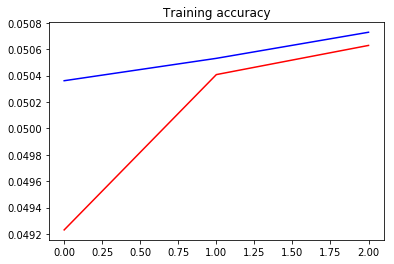

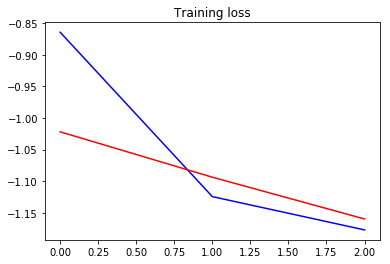

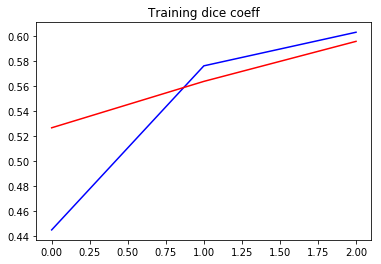

<Figure size 432x288 with 0 Axes>

In [36]:
plot_training(history)

#### Are the lower layers still not trainable?

In [37]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_256x1600_initially = layer.get_weights()[0][2][2][15]
print(layer_256x1600_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.19774145  0.0426113   0.00757337 -0.06391622  0.10728361  0.08970336
  0.09039313 -0.1798031   0.07129601  0.01274211 -0.15537432  0.01191017
 -0.18142171 -0.13882028  0.03663984 -0.03118151]


#### Lets make the layers trainable

In [38]:
# Takes roughly a minute
for idx in range(4, 96):
    layer_256x1600 = advanced_model.get_layer(index=(idx + 7))
    layer_256x1600.trainable=True


In [39]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

{'name': 'conv2d_4', 'trainable': True, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [40]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [43]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.015,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


 131/1419 [=>............................] - ETA: 7:30:39 - loss: -1.4858 - dice_coeff: 0.7605 - acc: 0.13 - ETA: 3:52:36 - loss: -1.3222 - dice_coeff: 0.6768 - acc: 0.08 - ETA: 2:39:54 - loss: -1.1553 - dice_coeff: 0.5911 - acc: 0.06 - ETA: 2:03:29 - loss: -1.1698 - dice_coeff: 0.5956 - acc: 0.04 - ETA: 1:41:47 - loss: -1.0738 - dice_coeff: 0.5473 - acc: 0.04 - ETA: 1:27:12 - loss: -1.1035 - dice_coeff: 0.5636 - acc: 0.04 - ETA: 1:16:51 - loss: -1.1375 - dice_coeff: 0.5810 - acc: 0.04 - ETA: 1:09:06 - loss: -1.1823 - dice_coeff: 0.6035 - acc: 0.05 - ETA: 1:07:14 - loss: -1.2085 - dice_coeff: 0.6179 - acc: 0.06 - ETA: 1:05:51 - loss: -1.2130 - dice_coeff: 0.6217 - acc: 0.06 - ETA: 1:04:32 - loss: -1.1889 - dice_coeff: 0.6100 - acc: 0.06 - ETA: 1:03:31 - loss: -1.1969 - dice_coeff: 0.6143 - acc: 0.06 - ETA: 1:02:34 - loss: -1.2069 - dice_coeff: 0.6189 - acc: 0.06 - ETA: 1:01:35 - loss: -1.1789 - dice_coeff: 0.6055 - acc: 0.06 - ETA: 1:01:02 - loss: -1.1904 - dice_coeff: 0.6106 - acc: 0.

 263/1419 [====>.........................] - ETA: 48:22 - loss: -1.1339 - dice_coeff: 0.5833 - acc: 0.04 - ETA: 48:18 - loss: -1.1272 - dice_coeff: 0.5800 - acc: 0.04 - ETA: 48:15 - loss: -1.1286 - dice_coeff: 0.5807 - acc: 0.04 - ETA: 48:12 - loss: -1.1301 - dice_coeff: 0.5817 - acc: 0.05 - ETA: 48:09 - loss: -1.1297 - dice_coeff: 0.5814 - acc: 0.05 - ETA: 48:06 - loss: -1.1288 - dice_coeff: 0.5810 - acc: 0.04 - ETA: 48:04 - loss: -1.1273 - dice_coeff: 0.5801 - acc: 0.04 - ETA: 48:02 - loss: -1.1275 - dice_coeff: 0.5801 - acc: 0.04 - ETA: 48:00 - loss: -1.1247 - dice_coeff: 0.5789 - acc: 0.04 - ETA: 47:57 - loss: -1.1281 - dice_coeff: 0.5805 - acc: 0.04 - ETA: 47:55 - loss: -1.1290 - dice_coeff: 0.5809 - acc: 0.04 - ETA: 47:52 - loss: -1.1303 - dice_coeff: 0.5815 - acc: 0.04 - ETA: 47:49 - loss: -1.1321 - dice_coeff: 0.5823 - acc: 0.04 - ETA: 47:47 - loss: -1.1333 - dice_coeff: 0.5829 - acc: 0.04 - ETA: 47:45 - loss: -1.1336 - dice_coeff: 0.5829 - acc: 0.04 - ETA: 47:41 - loss: -1.133

 395/1419 [=======>......................] - ETA: 42:51 - loss: -1.1614 - dice_coeff: 0.5969 - acc: 0.04 - ETA: 42:49 - loss: -1.1625 - dice_coeff: 0.5973 - acc: 0.04 - ETA: 42:47 - loss: -1.1605 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 42:45 - loss: -1.1611 - dice_coeff: 0.5969 - acc: 0.05 - ETA: 42:45 - loss: -1.1570 - dice_coeff: 0.5949 - acc: 0.05 - ETA: 42:43 - loss: -1.1566 - dice_coeff: 0.5947 - acc: 0.05 - ETA: 42:40 - loss: -1.1568 - dice_coeff: 0.5948 - acc: 0.05 - ETA: 42:38 - loss: -1.1582 - dice_coeff: 0.5955 - acc: 0.05 - ETA: 42:35 - loss: -1.1583 - dice_coeff: 0.5955 - acc: 0.05 - ETA: 42:33 - loss: -1.1590 - dice_coeff: 0.5958 - acc: 0.05 - ETA: 42:30 - loss: -1.1597 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 42:28 - loss: -1.1599 - dice_coeff: 0.5962 - acc: 0.05 - ETA: 42:26 - loss: -1.1594 - dice_coeff: 0.5960 - acc: 0.05 - ETA: 42:23 - loss: -1.1611 - dice_coeff: 0.5968 - acc: 0.05 - ETA: 42:20 - loss: -1.1613 - dice_coeff: 0.5969 - acc: 0.05 - ETA: 42:18 - loss: -1.162

 527/1419 [==========>...................] - ETA: 37:44 - loss: -1.1646 - dice_coeff: 0.5987 - acc: 0.05 - ETA: 37:42 - loss: -1.1644 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 37:39 - loss: -1.1639 - dice_coeff: 0.5983 - acc: 0.04 - ETA: 37:37 - loss: -1.1638 - dice_coeff: 0.5982 - acc: 0.04 - ETA: 37:35 - loss: -1.1630 - dice_coeff: 0.5978 - acc: 0.04 - ETA: 37:33 - loss: -1.1639 - dice_coeff: 0.5982 - acc: 0.04 - ETA: 37:30 - loss: -1.1636 - dice_coeff: 0.5982 - acc: 0.04 - ETA: 37:28 - loss: -1.1631 - dice_coeff: 0.5979 - acc: 0.04 - ETA: 37:26 - loss: -1.1614 - dice_coeff: 0.5971 - acc: 0.04 - ETA: 37:23 - loss: -1.1619 - dice_coeff: 0.5974 - acc: 0.04 - ETA: 37:21 - loss: -1.1623 - dice_coeff: 0.5975 - acc: 0.04 - ETA: 37:18 - loss: -1.1618 - dice_coeff: 0.5973 - acc: 0.04 - ETA: 37:16 - loss: -1.1623 - dice_coeff: 0.5975 - acc: 0.04 - ETA: 37:14 - loss: -1.1631 - dice_coeff: 0.5979 - acc: 0.04 - ETA: 37:11 - loss: -1.1633 - dice_coeff: 0.5980 - acc: 0.04 - ETA: 37:09 - loss: -1.163

 659/1419 [============>.................] - ETA: 32:51 - loss: -1.1614 - dice_coeff: 0.5969 - acc: 0.04 - ETA: 32:49 - loss: -1.1613 - dice_coeff: 0.5969 - acc: 0.04 - ETA: 32:47 - loss: -1.1617 - dice_coeff: 0.5970 - acc: 0.04 - ETA: 32:45 - loss: -1.1619 - dice_coeff: 0.5971 - acc: 0.04 - ETA: 32:42 - loss: -1.1613 - dice_coeff: 0.5968 - acc: 0.04 - ETA: 32:40 - loss: -1.1611 - dice_coeff: 0.5968 - acc: 0.04 - ETA: 32:38 - loss: -1.1621 - dice_coeff: 0.5972 - acc: 0.04 - ETA: 32:36 - loss: -1.1616 - dice_coeff: 0.5970 - acc: 0.04 - ETA: 32:33 - loss: -1.1616 - dice_coeff: 0.5970 - acc: 0.04 - ETA: 32:31 - loss: -1.1624 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 32:29 - loss: -1.1616 - dice_coeff: 0.5970 - acc: 0.05 - ETA: 32:27 - loss: -1.1621 - dice_coeff: 0.5972 - acc: 0.05 - ETA: 32:24 - loss: -1.1615 - dice_coeff: 0.5969 - acc: 0.05 - ETA: 32:22 - loss: -1.1614 - dice_coeff: 0.5969 - acc: 0.05 - ETA: 32:20 - loss: -1.1617 - dice_coeff: 0.5970 - acc: 0.05 - ETA: 32:18 - loss: -1.162

 791/1419 [===============>..............] - ETA: 27:56 - loss: -1.1666 - dice_coeff: 0.5995 - acc: 0.05 - ETA: 27:54 - loss: -1.1654 - dice_coeff: 0.5990 - acc: 0.05 - ETA: 27:52 - loss: -1.1660 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 27:50 - loss: -1.1656 - dice_coeff: 0.5990 - acc: 0.05 - ETA: 27:47 - loss: -1.1654 - dice_coeff: 0.5989 - acc: 0.05 - ETA: 27:45 - loss: -1.1655 - dice_coeff: 0.5990 - acc: 0.05 - ETA: 27:43 - loss: -1.1660 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 27:41 - loss: -1.1659 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 27:38 - loss: -1.1644 - dice_coeff: 0.5984 - acc: 0.05 - ETA: 27:36 - loss: -1.1645 - dice_coeff: 0.5984 - acc: 0.05 - ETA: 27:34 - loss: -1.1649 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 27:32 - loss: -1.1640 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 27:29 - loss: -1.1644 - dice_coeff: 0.5984 - acc: 0.05 - ETA: 27:27 - loss: -1.1640 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 27:25 - loss: -1.1639 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 27:23 - loss: -1.163

 923/1419 [==================>...........] - ETA: 23:03 - loss: -1.1638 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 23:01 - loss: -1.1638 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 22:59 - loss: -1.1638 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 22:57 - loss: -1.1633 - dice_coeff: 0.5980 - acc: 0.05 - ETA: 22:54 - loss: -1.1632 - dice_coeff: 0.5979 - acc: 0.05 - ETA: 22:52 - loss: -1.1629 - dice_coeff: 0.5977 - acc: 0.05 - ETA: 22:50 - loss: -1.1635 - dice_coeff: 0.5980 - acc: 0.05 - ETA: 22:48 - loss: -1.1639 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 22:46 - loss: -1.1647 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 22:43 - loss: -1.1650 - dice_coeff: 0.5988 - acc: 0.05 - ETA: 22:41 - loss: -1.1649 - dice_coeff: 0.5987 - acc: 0.05 - ETA: 22:39 - loss: -1.1642 - dice_coeff: 0.5984 - acc: 0.05 - ETA: 22:37 - loss: -1.1639 - dice_coeff: 0.5982 - acc: 0.05 - ETA: 22:34 - loss: -1.1644 - dice_coeff: 0.5985 - acc: 0.05 - ETA: 22:32 - loss: -1.1644 - dice_coeff: 0.5985 - acc: 0.05 - ETA: 22:30 - loss: -1.164

1055/1419 [=====================>........] - ETA: 18:11 - loss: -1.1710 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 18:08 - loss: -1.1713 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 18:06 - loss: -1.1713 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 18:04 - loss: -1.1708 - dice_coeff: 0.6014 - acc: 0.05 - ETA: 18:02 - loss: -1.1710 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 18:00 - loss: -1.1708 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 17:57 - loss: -1.1713 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 17:55 - loss: -1.1709 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 17:53 - loss: -1.1712 - dice_coeff: 0.6016 - acc: 0.05 - ETA: 17:51 - loss: -1.1712 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 17:49 - loss: -1.1714 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 17:46 - loss: -1.1717 - dice_coeff: 0.6019 - acc: 0.05 - ETA: 17:44 - loss: -1.1716 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 17:42 - loss: -1.1709 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 17:40 - loss: -1.1713 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 17:37 - loss: -1.171

1187/1419 [========================>.....] - ETA: 13:19 - loss: -1.1710 - dice_coeff: 0.6016 - acc: 0.05 - ETA: 13:17 - loss: -1.1711 - dice_coeff: 0.6016 - acc: 0.05 - ETA: 13:15 - loss: -1.1715 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 13:12 - loss: -1.1716 - dice_coeff: 0.6019 - acc: 0.05 - ETA: 13:10 - loss: -1.1716 - dice_coeff: 0.6019 - acc: 0.05 - ETA: 13:08 - loss: -1.1714 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 13:06 - loss: -1.1718 - dice_coeff: 0.6020 - acc: 0.05 - ETA: 13:04 - loss: -1.1718 - dice_coeff: 0.6020 - acc: 0.05 - ETA: 13:01 - loss: -1.1714 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 12:59 - loss: -1.1712 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 12:57 - loss: -1.1713 - dice_coeff: 0.6018 - acc: 0.05 - ETA: 12:55 - loss: -1.1716 - dice_coeff: 0.6019 - acc: 0.05 - ETA: 12:52 - loss: -1.1710 - dice_coeff: 0.6016 - acc: 0.05 - ETA: 12:50 - loss: -1.1708 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 12:48 - loss: -1.1709 - dice_coeff: 0.6016 - acc: 0.05 - ETA: 12:46 - loss: -1.170

1319/1419 [==========================>...] - ETA: 8:28 - loss: -1.1619 - dice_coeff: 0.5973 - acc: 0.050 - ETA: 8:26 - loss: -1.1613 - dice_coeff: 0.5970 - acc: 0.050 - ETA: 8:23 - loss: -1.1615 - dice_coeff: 0.5971 - acc: 0.050 - ETA: 8:21 - loss: -1.1612 - dice_coeff: 0.5969 - acc: 0.050 - ETA: 8:19 - loss: -1.1606 - dice_coeff: 0.5967 - acc: 0.050 - ETA: 8:17 - loss: -1.1604 - dice_coeff: 0.5966 - acc: 0.050 - ETA: 8:15 - loss: -1.1607 - dice_coeff: 0.5967 - acc: 0.050 - ETA: 8:12 - loss: -1.1607 - dice_coeff: 0.5967 - acc: 0.050 - ETA: 8:10 - loss: -1.1607 - dice_coeff: 0.5967 - acc: 0.050 - ETA: 8:08 - loss: -1.1609 - dice_coeff: 0.5968 - acc: 0.050 - ETA: 8:06 - loss: -1.1612 - dice_coeff: 0.5970 - acc: 0.050 - ETA: 8:04 - loss: -1.1614 - dice_coeff: 0.5970 - acc: 0.050 - ETA: 8:02 - loss: -1.1608 - dice_coeff: 0.5968 - acc: 0.050 - ETA: 7:59 - loss: -1.1611 - dice_coeff: 0.5969 - acc: 0.050 - ETA: 7:57 - loss: -1.1614 - dice_coeff: 0.5970 - acc: 0.050 - ETA: 7:55 - loss: -1.1616

1419/1419 [==============================] - ETA: 3:37 - loss: -1.1581 - dice_coeff: 0.5955 - acc: 0.050 - ETA: 3:35 - loss: -1.1584 - dice_coeff: 0.5957 - acc: 0.050 - ETA: 3:33 - loss: -1.1586 - dice_coeff: 0.5958 - acc: 0.050 - ETA: 3:31 - loss: -1.1589 - dice_coeff: 0.5959 - acc: 0.050 - ETA: 3:28 - loss: -1.1590 - dice_coeff: 0.5960 - acc: 0.050 - ETA: 3:26 - loss: -1.1592 - dice_coeff: 0.5961 - acc: 0.050 - ETA: 3:24 - loss: -1.1594 - dice_coeff: 0.5962 - acc: 0.050 - ETA: 3:22 - loss: -1.1596 - dice_coeff: 0.5963 - acc: 0.050 - ETA: 3:20 - loss: -1.1599 - dice_coeff: 0.5964 - acc: 0.050 - ETA: 3:17 - loss: -1.1601 - dice_coeff: 0.5965 - acc: 0.050 - ETA: 3:15 - loss: -1.1601 - dice_coeff: 0.5965 - acc: 0.050 - ETA: 3:13 - loss: -1.1600 - dice_coeff: 0.5965 - acc: 0.050 - ETA: 3:11 - loss: -1.1603 - dice_coeff: 0.5966 - acc: 0.050 - ETA: 3:09 - loss: -1.1604 - dice_coeff: 0.5967 - acc: 0.050 - ETA: 3:06 - loss: -1.1602 - dice_coeff: 0.5966 - acc: 0.050 - ETA: 3:04 - loss: -1.1604

 132/1419 [=>............................] - ETA: 15:36 - loss: -1.3949 - dice_coeff: 0.7034 - acc: 0.02 - ETA: 15:29 - loss: -1.1578 - dice_coeff: 0.6084 - acc: 0.08 - ETA: 15:26 - loss: -1.1016 - dice_coeff: 0.5777 - acc: 0.06 - ETA: 15:24 - loss: -1.1327 - dice_coeff: 0.5935 - acc: 0.07 - ETA: 15:21 - loss: -1.1229 - dice_coeff: 0.5849 - acc: 0.06 - ETA: 15:27 - loss: -1.1572 - dice_coeff: 0.5991 - acc: 0.05 - ETA: 15:29 - loss: -1.1269 - dice_coeff: 0.5822 - acc: 0.04 - ETA: 15:28 - loss: -1.1748 - dice_coeff: 0.6054 - acc: 0.05 - ETA: 15:27 - loss: -1.1312 - dice_coeff: 0.5833 - acc: 0.04 - ETA: 15:24 - loss: -1.1123 - dice_coeff: 0.5744 - acc: 0.04 - ETA: 15:24 - loss: -1.0908 - dice_coeff: 0.5630 - acc: 0.04 - ETA: 15:25 - loss: -1.0703 - dice_coeff: 0.5524 - acc: 0.04 - ETA: 15:25 - loss: -1.0773 - dice_coeff: 0.5561 - acc: 0.04 - ETA: 17:09 - loss: -1.0760 - dice_coeff: 0.5554 - acc: 0.04 - ETA: 19:21 - loss: -1.1024 - dice_coeff: 0.5686 - acc: 0.04 - ETA: 21:18 - loss: -1.078

 264/1419 [====>.........................] - ETA: 41:29 - loss: -1.1871 - dice_coeff: 0.6094 - acc: 0.05 - ETA: 41:29 - loss: -1.1900 - dice_coeff: 0.6108 - acc: 0.05 - ETA: 41:29 - loss: -1.1910 - dice_coeff: 0.6113 - acc: 0.05 - ETA: 41:33 - loss: -1.1935 - dice_coeff: 0.6125 - acc: 0.05 - ETA: 41:32 - loss: -1.1949 - dice_coeff: 0.6133 - acc: 0.05 - ETA: 41:31 - loss: -1.1963 - dice_coeff: 0.6140 - acc: 0.05 - ETA: 41:31 - loss: -1.1904 - dice_coeff: 0.6110 - acc: 0.05 - ETA: 41:31 - loss: -1.1875 - dice_coeff: 0.6098 - acc: 0.05 - ETA: 41:30 - loss: -1.1857 - dice_coeff: 0.6089 - acc: 0.05 - ETA: 41:29 - loss: -1.1860 - dice_coeff: 0.6090 - acc: 0.05 - ETA: 41:28 - loss: -1.1869 - dice_coeff: 0.6094 - acc: 0.05 - ETA: 41:26 - loss: -1.1863 - dice_coeff: 0.6094 - acc: 0.05 - ETA: 41:25 - loss: -1.1896 - dice_coeff: 0.6110 - acc: 0.05 - ETA: 41:25 - loss: -1.1898 - dice_coeff: 0.6110 - acc: 0.05 - ETA: 41:26 - loss: -1.1888 - dice_coeff: 0.6105 - acc: 0.05 - ETA: 41:25 - loss: -1.190

 396/1419 [=======>......................] - ETA: 38:35 - loss: -1.2043 - dice_coeff: 0.6182 - acc: 0.05 - ETA: 38:34 - loss: -1.2011 - dice_coeff: 0.6167 - acc: 0.05 - ETA: 38:32 - loss: -1.2006 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 38:30 - loss: -1.2001 - dice_coeff: 0.6161 - acc: 0.05 - ETA: 38:28 - loss: -1.2009 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 38:27 - loss: -1.2017 - dice_coeff: 0.6168 - acc: 0.05 - ETA: 38:25 - loss: -1.2028 - dice_coeff: 0.6173 - acc: 0.05 - ETA: 38:23 - loss: -1.2022 - dice_coeff: 0.6171 - acc: 0.05 - ETA: 38:21 - loss: -1.2008 - dice_coeff: 0.6165 - acc: 0.05 - ETA: 38:19 - loss: -1.2006 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 38:17 - loss: -1.2016 - dice_coeff: 0.6169 - acc: 0.05 - ETA: 38:15 - loss: -1.2020 - dice_coeff: 0.6170 - acc: 0.05 - ETA: 38:14 - loss: -1.2007 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 38:13 - loss: -1.2006 - dice_coeff: 0.6163 - acc: 0.05 - ETA: 38:11 - loss: -1.1993 - dice_coeff: 0.6157 - acc: 0.05 - ETA: 38:09 - loss: -1.200

 528/1419 [==========>...................] - ETA: 34:36 - loss: -1.1813 - dice_coeff: 0.6070 - acc: 0.05 - ETA: 34:34 - loss: -1.1819 - dice_coeff: 0.6072 - acc: 0.05 - ETA: 34:32 - loss: -1.1825 - dice_coeff: 0.6075 - acc: 0.05 - ETA: 34:30 - loss: -1.1835 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 34:28 - loss: -1.1833 - dice_coeff: 0.6079 - acc: 0.05 - ETA: 34:26 - loss: -1.1840 - dice_coeff: 0.6082 - acc: 0.05 - ETA: 34:24 - loss: -1.1835 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 34:22 - loss: -1.1842 - dice_coeff: 0.6083 - acc: 0.05 - ETA: 34:20 - loss: -1.1834 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 34:18 - loss: -1.1836 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 34:16 - loss: -1.1832 - dice_coeff: 0.6078 - acc: 0.04 - ETA: 34:14 - loss: -1.1841 - dice_coeff: 0.6082 - acc: 0.04 - ETA: 34:13 - loss: -1.1836 - dice_coeff: 0.6080 - acc: 0.04 - ETA: 34:11 - loss: -1.1828 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 34:09 - loss: -1.1840 - dice_coeff: 0.6082 - acc: 0.05 - ETA: 34:07 - loss: -1.184

 660/1419 [============>.................] - ETA: 30:17 - loss: -1.1809 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 30:15 - loss: -1.1816 - dice_coeff: 0.6071 - acc: 0.05 - ETA: 30:13 - loss: -1.1810 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 30:11 - loss: -1.1810 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 30:09 - loss: -1.1809 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 30:07 - loss: -1.1813 - dice_coeff: 0.6069 - acc: 0.05 - ETA: 30:05 - loss: -1.1818 - dice_coeff: 0.6071 - acc: 0.05 - ETA: 30:03 - loss: -1.1815 - dice_coeff: 0.6070 - acc: 0.05 - ETA: 30:01 - loss: -1.1803 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 29:59 - loss: -1.1808 - dice_coeff: 0.6066 - acc: 0.05 - ETA: 29:57 - loss: -1.1810 - dice_coeff: 0.6068 - acc: 0.05 - ETA: 29:55 - loss: -1.1820 - dice_coeff: 0.6072 - acc: 0.05 - ETA: 29:53 - loss: -1.1817 - dice_coeff: 0.6071 - acc: 0.05 - ETA: 29:51 - loss: -1.1820 - dice_coeff: 0.6072 - acc: 0.05 - ETA: 29:49 - loss: -1.1818 - dice_coeff: 0.6071 - acc: 0.05 - ETA: 29:47 - loss: -1.181

 792/1419 [===============>..............] - ETA: 25:54 - loss: -1.1861 - dice_coeff: 0.6091 - acc: 0.05 - ETA: 25:52 - loss: -1.1863 - dice_coeff: 0.6092 - acc: 0.05 - ETA: 25:50 - loss: -1.1862 - dice_coeff: 0.6091 - acc: 0.05 - ETA: 25:48 - loss: -1.1865 - dice_coeff: 0.6093 - acc: 0.05 - ETA: 25:46 - loss: -1.1871 - dice_coeff: 0.6096 - acc: 0.05 - ETA: 25:44 - loss: -1.1874 - dice_coeff: 0.6097 - acc: 0.05 - ETA: 25:42 - loss: -1.1873 - dice_coeff: 0.6096 - acc: 0.05 - ETA: 25:40 - loss: -1.1878 - dice_coeff: 0.6099 - acc: 0.05 - ETA: 25:38 - loss: -1.1885 - dice_coeff: 0.6102 - acc: 0.05 - ETA: 25:36 - loss: -1.1891 - dice_coeff: 0.6105 - acc: 0.05 - ETA: 25:34 - loss: -1.1887 - dice_coeff: 0.6103 - acc: 0.05 - ETA: 25:32 - loss: -1.1877 - dice_coeff: 0.6098 - acc: 0.05 - ETA: 25:30 - loss: -1.1881 - dice_coeff: 0.6100 - acc: 0.05 - ETA: 25:28 - loss: -1.1881 - dice_coeff: 0.6100 - acc: 0.05 - ETA: 25:26 - loss: -1.1886 - dice_coeff: 0.6102 - acc: 0.05 - ETA: 25:24 - loss: -1.188

 924/1419 [==================>...........] - ETA: 21:26 - loss: -1.1961 - dice_coeff: 0.6140 - acc: 0.05 - ETA: 21:24 - loss: -1.1965 - dice_coeff: 0.6142 - acc: 0.05 - ETA: 21:22 - loss: -1.1971 - dice_coeff: 0.6145 - acc: 0.05 - ETA: 21:20 - loss: -1.1977 - dice_coeff: 0.6148 - acc: 0.05 - ETA: 21:18 - loss: -1.1979 - dice_coeff: 0.6149 - acc: 0.05 - ETA: 21:16 - loss: -1.1977 - dice_coeff: 0.6148 - acc: 0.05 - ETA: 21:14 - loss: -1.1980 - dice_coeff: 0.6149 - acc: 0.05 - ETA: 21:12 - loss: -1.1985 - dice_coeff: 0.6152 - acc: 0.05 - ETA: 21:10 - loss: -1.1985 - dice_coeff: 0.6151 - acc: 0.05 - ETA: 21:08 - loss: -1.1990 - dice_coeff: 0.6154 - acc: 0.05 - ETA: 21:06 - loss: -1.1991 - dice_coeff: 0.6154 - acc: 0.05 - ETA: 21:04 - loss: -1.1991 - dice_coeff: 0.6155 - acc: 0.05 - ETA: 21:02 - loss: -1.1983 - dice_coeff: 0.6151 - acc: 0.05 - ETA: 21:00 - loss: -1.1987 - dice_coeff: 0.6153 - acc: 0.05 - ETA: 20:58 - loss: -1.1990 - dice_coeff: 0.6154 - acc: 0.05 - ETA: 20:56 - loss: -1.198

1056/1419 [=====================>........] - ETA: 16:57 - loss: -1.1999 - dice_coeff: 0.6158 - acc: 0.05 - ETA: 16:55 - loss: -1.2002 - dice_coeff: 0.6160 - acc: 0.05 - ETA: 16:53 - loss: -1.2003 - dice_coeff: 0.6160 - acc: 0.05 - ETA: 16:50 - loss: -1.2001 - dice_coeff: 0.6159 - acc: 0.05 - ETA: 16:48 - loss: -1.1995 - dice_coeff: 0.6156 - acc: 0.05 - ETA: 16:46 - loss: -1.1992 - dice_coeff: 0.6154 - acc: 0.05 - ETA: 16:44 - loss: -1.1982 - dice_coeff: 0.6149 - acc: 0.05 - ETA: 16:42 - loss: -1.1983 - dice_coeff: 0.6150 - acc: 0.05 - ETA: 16:40 - loss: -1.1983 - dice_coeff: 0.6150 - acc: 0.05 - ETA: 16:38 - loss: -1.1983 - dice_coeff: 0.6151 - acc: 0.05 - ETA: 16:36 - loss: -1.1987 - dice_coeff: 0.6152 - acc: 0.05 - ETA: 16:34 - loss: -1.1989 - dice_coeff: 0.6153 - acc: 0.05 - ETA: 16:32 - loss: -1.1992 - dice_coeff: 0.6155 - acc: 0.05 - ETA: 16:30 - loss: -1.1994 - dice_coeff: 0.6156 - acc: 0.05 - ETA: 16:28 - loss: -1.1993 - dice_coeff: 0.6155 - acc: 0.05 - ETA: 16:26 - loss: -1.199

1188/1419 [========================>.....] - ETA: 12:26 - loss: -1.2057 - dice_coeff: 0.6186 - acc: 0.05 - ETA: 12:24 - loss: -1.2057 - dice_coeff: 0.6185 - acc: 0.05 - ETA: 12:22 - loss: -1.2062 - dice_coeff: 0.6188 - acc: 0.05 - ETA: 12:20 - loss: -1.2061 - dice_coeff: 0.6187 - acc: 0.05 - ETA: 12:18 - loss: -1.2065 - dice_coeff: 0.6189 - acc: 0.05 - ETA: 12:16 - loss: -1.2069 - dice_coeff: 0.6191 - acc: 0.05 - ETA: 12:13 - loss: -1.2071 - dice_coeff: 0.6192 - acc: 0.05 - ETA: 12:11 - loss: -1.2073 - dice_coeff: 0.6193 - acc: 0.05 - ETA: 12:10 - loss: -1.2070 - dice_coeff: 0.6192 - acc: 0.05 - ETA: 12:08 - loss: -1.2067 - dice_coeff: 0.6190 - acc: 0.05 - ETA: 12:05 - loss: -1.2067 - dice_coeff: 0.6190 - acc: 0.05 - ETA: 12:03 - loss: -1.2063 - dice_coeff: 0.6188 - acc: 0.05 - ETA: 12:01 - loss: -1.2062 - dice_coeff: 0.6187 - acc: 0.05 - ETA: 11:59 - loss: -1.2057 - dice_coeff: 0.6185 - acc: 0.05 - ETA: 11:57 - loss: -1.2057 - dice_coeff: 0.6185 - acc: 0.05 - ETA: 11:55 - loss: -1.205

1320/1419 [==========================>...] - ETA: 7:54 - loss: -1.2055 - dice_coeff: 0.6182 - acc: 0.050 - ETA: 7:52 - loss: -1.2055 - dice_coeff: 0.6182 - acc: 0.050 - ETA: 7:50 - loss: -1.2049 - dice_coeff: 0.6180 - acc: 0.050 - ETA: 7:48 - loss: -1.2045 - dice_coeff: 0.6178 - acc: 0.050 - ETA: 7:46 - loss: -1.2044 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:44 - loss: -1.2041 - dice_coeff: 0.6176 - acc: 0.050 - ETA: 7:42 - loss: -1.2043 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:40 - loss: -1.2044 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:38 - loss: -1.2043 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:36 - loss: -1.2043 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:34 - loss: -1.2045 - dice_coeff: 0.6178 - acc: 0.050 - ETA: 7:32 - loss: -1.2047 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 7:30 - loss: -1.2044 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 7:27 - loss: -1.2046 - dice_coeff: 0.6178 - acc: 0.050 - ETA: 7:25 - loss: -1.2049 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 7:23 - loss: -1.2044

1419/1419 [==============================] - ETA: 3:22 - loss: -1.1996 - dice_coeff: 0.6155 - acc: 0.050 - ETA: 3:20 - loss: -1.1996 - dice_coeff: 0.6155 - acc: 0.050 - ETA: 3:18 - loss: -1.1997 - dice_coeff: 0.6156 - acc: 0.050 - ETA: 3:16 - loss: -1.1999 - dice_coeff: 0.6157 - acc: 0.050 - ETA: 3:14 - loss: -1.1992 - dice_coeff: 0.6153 - acc: 0.050 - ETA: 3:12 - loss: -1.1991 - dice_coeff: 0.6153 - acc: 0.050 - ETA: 3:09 - loss: -1.1991 - dice_coeff: 0.6153 - acc: 0.050 - ETA: 3:07 - loss: -1.1991 - dice_coeff: 0.6153 - acc: 0.050 - ETA: 3:05 - loss: -1.1994 - dice_coeff: 0.6154 - acc: 0.050 - ETA: 3:03 - loss: -1.1996 - dice_coeff: 0.6155 - acc: 0.050 - ETA: 3:01 - loss: -1.1995 - dice_coeff: 0.6155 - acc: 0.050 - ETA: 2:59 - loss: -1.1992 - dice_coeff: 0.6153 - acc: 0.050 - ETA: 2:57 - loss: -1.1993 - dice_coeff: 0.6154 - acc: 0.050 - ETA: 2:55 - loss: -1.1996 - dice_coeff: 0.6155 - acc: 0.050 - ETA: 2:53 - loss: -1.1993 - dice_coeff: 0.6154 - acc: 0.050 - ETA: 2:51 - loss: -1.1996

 132/1419 [=>............................] - ETA: 15:29 - loss: -1.0661 - dice_coeff: 0.5800 - acc: 0.12 - ETA: 15:37 - loss: -1.2477 - dice_coeff: 0.6566 - acc: 0.11 - ETA: 15:24 - loss: -1.2913 - dice_coeff: 0.6712 - acc: 0.08 - ETA: 15:22 - loss: -1.2340 - dice_coeff: 0.6402 - acc: 0.07 - ETA: 15:25 - loss: -1.1930 - dice_coeff: 0.6199 - acc: 0.06 - ETA: 15:24 - loss: -1.2335 - dice_coeff: 0.6382 - acc: 0.06 - ETA: 15:22 - loss: -1.2494 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 15:21 - loss: -1.2250 - dice_coeff: 0.6333 - acc: 0.06 - ETA: 15:20 - loss: -1.2121 - dice_coeff: 0.6256 - acc: 0.06 - ETA: 15:19 - loss: -1.2546 - dice_coeff: 0.6456 - acc: 0.05 - ETA: 15:18 - loss: -1.1864 - dice_coeff: 0.6123 - acc: 0.05 - ETA: 15:17 - loss: -1.2295 - dice_coeff: 0.6327 - acc: 0.05 - ETA: 15:16 - loss: -1.1491 - dice_coeff: 0.5929 - acc: 0.05 - ETA: 17:13 - loss: -1.1771 - dice_coeff: 0.6078 - acc: 0.06 - ETA: 19:53 - loss: -1.2026 - dice_coeff: 0.6202 - acc: 0.06 - ETA: 22:00 - loss: -1.208

 264/1419 [====>.........................] - ETA: 43:33 - loss: -1.2218 - dice_coeff: 0.6251 - acc: 0.04 - ETA: 43:33 - loss: -1.2197 - dice_coeff: 0.6240 - acc: 0.04 - ETA: 43:32 - loss: -1.2138 - dice_coeff: 0.6214 - acc: 0.04 - ETA: 43:31 - loss: -1.2156 - dice_coeff: 0.6222 - acc: 0.04 - ETA: 43:30 - loss: -1.2134 - dice_coeff: 0.6211 - acc: 0.04 - ETA: 43:29 - loss: -1.2066 - dice_coeff: 0.6179 - acc: 0.04 - ETA: 43:28 - loss: -1.2050 - dice_coeff: 0.6170 - acc: 0.04 - ETA: 43:28 - loss: -1.2038 - dice_coeff: 0.6164 - acc: 0.04 - ETA: 43:27 - loss: -1.2042 - dice_coeff: 0.6166 - acc: 0.04 - ETA: 43:25 - loss: -1.2043 - dice_coeff: 0.6166 - acc: 0.04 - ETA: 43:27 - loss: -1.2056 - dice_coeff: 0.6172 - acc: 0.04 - ETA: 43:25 - loss: -1.2063 - dice_coeff: 0.6175 - acc: 0.04 - ETA: 43:24 - loss: -1.2086 - dice_coeff: 0.6187 - acc: 0.04 - ETA: 43:23 - loss: -1.2108 - dice_coeff: 0.6198 - acc: 0.04 - ETA: 43:21 - loss: -1.2131 - dice_coeff: 0.6208 - acc: 0.04 - ETA: 43:21 - loss: -1.213

 396/1419 [=======>......................] - ETA: 40:27 - loss: -1.2202 - dice_coeff: 0.6248 - acc: 0.05 - ETA: 40:25 - loss: -1.2215 - dice_coeff: 0.6255 - acc: 0.05 - ETA: 40:23 - loss: -1.2221 - dice_coeff: 0.6257 - acc: 0.05 - ETA: 40:21 - loss: -1.2202 - dice_coeff: 0.6248 - acc: 0.05 - ETA: 40:19 - loss: -1.2204 - dice_coeff: 0.6249 - acc: 0.04 - ETA: 40:17 - loss: -1.2216 - dice_coeff: 0.6255 - acc: 0.04 - ETA: 40:15 - loss: -1.2220 - dice_coeff: 0.6256 - acc: 0.04 - ETA: 40:13 - loss: -1.2218 - dice_coeff: 0.6255 - acc: 0.04 - ETA: 40:12 - loss: -1.2201 - dice_coeff: 0.6247 - acc: 0.04 - ETA: 40:10 - loss: -1.2213 - dice_coeff: 0.6253 - acc: 0.05 - ETA: 40:09 - loss: -1.2222 - dice_coeff: 0.6258 - acc: 0.05 - ETA: 40:07 - loss: -1.2214 - dice_coeff: 0.6254 - acc: 0.05 - ETA: 40:05 - loss: -1.2227 - dice_coeff: 0.6260 - acc: 0.05 - ETA: 40:03 - loss: -1.2223 - dice_coeff: 0.6258 - acc: 0.04 - ETA: 40:01 - loss: -1.2226 - dice_coeff: 0.6259 - acc: 0.04 - ETA: 39:59 - loss: -1.223

 528/1419 [==========>...................] - ETA: 36:08 - loss: -1.2245 - dice_coeff: 0.6270 - acc: 0.05 - ETA: 36:06 - loss: -1.2230 - dice_coeff: 0.6262 - acc: 0.05 - ETA: 36:04 - loss: -1.2241 - dice_coeff: 0.6268 - acc: 0.05 - ETA: 36:02 - loss: -1.2250 - dice_coeff: 0.6272 - acc: 0.04 - ETA: 36:00 - loss: -1.2245 - dice_coeff: 0.6269 - acc: 0.04 - ETA: 35:58 - loss: -1.2242 - dice_coeff: 0.6268 - acc: 0.04 - ETA: 35:56 - loss: -1.2227 - dice_coeff: 0.6261 - acc: 0.04 - ETA: 35:54 - loss: -1.2226 - dice_coeff: 0.6261 - acc: 0.04 - ETA: 35:52 - loss: -1.2219 - dice_coeff: 0.6257 - acc: 0.04 - ETA: 35:50 - loss: -1.2219 - dice_coeff: 0.6257 - acc: 0.04 - ETA: 35:48 - loss: -1.2221 - dice_coeff: 0.6259 - acc: 0.04 - ETA: 35:46 - loss: -1.2224 - dice_coeff: 0.6260 - acc: 0.04 - ETA: 35:44 - loss: -1.2221 - dice_coeff: 0.6258 - acc: 0.04 - ETA: 35:42 - loss: -1.2216 - dice_coeff: 0.6256 - acc: 0.04 - ETA: 35:40 - loss: -1.2218 - dice_coeff: 0.6257 - acc: 0.04 - ETA: 35:38 - loss: -1.221

 660/1419 [============>.................] - ETA: 37:22 - loss: -1.2080 - dice_coeff: 0.6190 - acc: 0.04 - ETA: 37:19 - loss: -1.2076 - dice_coeff: 0.6188 - acc: 0.04 - ETA: 37:17 - loss: -1.2071 - dice_coeff: 0.6186 - acc: 0.04 - ETA: 37:14 - loss: -1.2077 - dice_coeff: 0.6189 - acc: 0.04 - ETA: 37:11 - loss: -1.2067 - dice_coeff: 0.6185 - acc: 0.04 - ETA: 37:08 - loss: -1.2069 - dice_coeff: 0.6186 - acc: 0.04 - ETA: 37:05 - loss: -1.2072 - dice_coeff: 0.6188 - acc: 0.04 - ETA: 37:02 - loss: -1.2070 - dice_coeff: 0.6187 - acc: 0.04 - ETA: 36:59 - loss: -1.2075 - dice_coeff: 0.6190 - acc: 0.05 - ETA: 36:56 - loss: -1.2069 - dice_coeff: 0.6187 - acc: 0.04 - ETA: 36:53 - loss: -1.2074 - dice_coeff: 0.6189 - acc: 0.05 - ETA: 36:50 - loss: -1.2076 - dice_coeff: 0.6190 - acc: 0.05 - ETA: 36:46 - loss: -1.2081 - dice_coeff: 0.6192 - acc: 0.04 - ETA: 36:44 - loss: -1.2086 - dice_coeff: 0.6195 - acc: 0.04 - ETA: 36:41 - loss: -1.2085 - dice_coeff: 0.6194 - acc: 0.04 - ETA: 36:38 - loss: -1.209

 792/1419 [===============>..............] - ETA: 31:06 - loss: -1.2128 - dice_coeff: 0.6215 - acc: 0.04 - ETA: 31:03 - loss: -1.2125 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 31:01 - loss: -1.2130 - dice_coeff: 0.6215 - acc: 0.04 - ETA: 30:58 - loss: -1.2136 - dice_coeff: 0.6218 - acc: 0.04 - ETA: 30:55 - loss: -1.2128 - dice_coeff: 0.6214 - acc: 0.04 - ETA: 30:53 - loss: -1.2127 - dice_coeff: 0.6214 - acc: 0.04 - ETA: 30:50 - loss: -1.2126 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 30:47 - loss: -1.2128 - dice_coeff: 0.6214 - acc: 0.04 - ETA: 30:44 - loss: -1.2127 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 30:42 - loss: -1.2130 - dice_coeff: 0.6215 - acc: 0.04 - ETA: 30:39 - loss: -1.2126 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 30:36 - loss: -1.2132 - dice_coeff: 0.6216 - acc: 0.04 - ETA: 30:34 - loss: -1.2129 - dice_coeff: 0.6215 - acc: 0.04 - ETA: 30:31 - loss: -1.2133 - dice_coeff: 0.6216 - acc: 0.04 - ETA: 30:28 - loss: -1.2139 - dice_coeff: 0.6219 - acc: 0.04 - ETA: 30:25 - loss: -1.213

 924/1419 [==================>...........] - ETA: 25:15 - loss: -1.2113 - dice_coeff: 0.6208 - acc: 0.04 - ETA: 25:12 - loss: -1.2111 - dice_coeff: 0.6207 - acc: 0.04 - ETA: 25:10 - loss: -1.2112 - dice_coeff: 0.6208 - acc: 0.04 - ETA: 25:07 - loss: -1.2116 - dice_coeff: 0.6210 - acc: 0.04 - ETA: 25:05 - loss: -1.2120 - dice_coeff: 0.6212 - acc: 0.04 - ETA: 25:02 - loss: -1.2123 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 25:00 - loss: -1.2128 - dice_coeff: 0.6215 - acc: 0.04 - ETA: 24:57 - loss: -1.2117 - dice_coeff: 0.6210 - acc: 0.04 - ETA: 24:54 - loss: -1.2118 - dice_coeff: 0.6211 - acc: 0.04 - ETA: 24:52 - loss: -1.2123 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 24:49 - loss: -1.2125 - dice_coeff: 0.6214 - acc: 0.04 - ETA: 24:47 - loss: -1.2129 - dice_coeff: 0.6216 - acc: 0.04 - ETA: 24:44 - loss: -1.2124 - dice_coeff: 0.6213 - acc: 0.04 - ETA: 24:41 - loss: -1.2129 - dice_coeff: 0.6216 - acc: 0.04 - ETA: 24:39 - loss: -1.2129 - dice_coeff: 0.6216 - acc: 0.04 - ETA: 24:36 - loss: -1.212

1056/1419 [=====================>........] - ETA: 19:40 - loss: -1.2082 - dice_coeff: 0.6195 - acc: 0.04 - ETA: 19:38 - loss: -1.2083 - dice_coeff: 0.6196 - acc: 0.04 - ETA: 19:35 - loss: -1.2082 - dice_coeff: 0.6195 - acc: 0.04 - ETA: 19:33 - loss: -1.2085 - dice_coeff: 0.6197 - acc: 0.04 - ETA: 19:30 - loss: -1.2084 - dice_coeff: 0.6197 - acc: 0.04 - ETA: 19:28 - loss: -1.2087 - dice_coeff: 0.6198 - acc: 0.04 - ETA: 19:25 - loss: -1.2082 - dice_coeff: 0.6196 - acc: 0.05 - ETA: 19:23 - loss: -1.2081 - dice_coeff: 0.6195 - acc: 0.05 - ETA: 19:20 - loss: -1.2085 - dice_coeff: 0.6197 - acc: 0.05 - ETA: 19:18 - loss: -1.2088 - dice_coeff: 0.6199 - acc: 0.05 - ETA: 19:15 - loss: -1.2093 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 19:13 - loss: -1.2093 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 19:11 - loss: -1.2097 - dice_coeff: 0.6203 - acc: 0.05 - ETA: 19:08 - loss: -1.2093 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 19:06 - loss: -1.2092 - dice_coeff: 0.6200 - acc: 0.05 - ETA: 19:03 - loss: -1.209

1188/1419 [========================>.....] - ETA: 14:16 - loss: -1.2091 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 14:14 - loss: -1.2095 - dice_coeff: 0.6203 - acc: 0.05 - ETA: 14:11 - loss: -1.2095 - dice_coeff: 0.6204 - acc: 0.05 - ETA: 14:09 - loss: -1.2099 - dice_coeff: 0.6206 - acc: 0.05 - ETA: 14:06 - loss: -1.2097 - dice_coeff: 0.6205 - acc: 0.05 - ETA: 14:04 - loss: -1.2095 - dice_coeff: 0.6204 - acc: 0.05 - ETA: 14:02 - loss: -1.2092 - dice_coeff: 0.6203 - acc: 0.05 - ETA: 13:59 - loss: -1.2089 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 13:57 - loss: -1.2091 - dice_coeff: 0.6202 - acc: 0.05 - ETA: 13:54 - loss: -1.2092 - dice_coeff: 0.6202 - acc: 0.05 - ETA: 13:52 - loss: -1.2088 - dice_coeff: 0.6200 - acc: 0.05 - ETA: 13:49 - loss: -1.2089 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 13:47 - loss: -1.2088 - dice_coeff: 0.6200 - acc: 0.05 - ETA: 13:45 - loss: -1.2090 - dice_coeff: 0.6201 - acc: 0.05 - ETA: 13:42 - loss: -1.2085 - dice_coeff: 0.6199 - acc: 0.05 - ETA: 13:40 - loss: -1.208

1320/1419 [==========================>...] - ETA: 8:59 - loss: -1.2123 - dice_coeff: 0.6218 - acc: 0.051 - ETA: 8:57 - loss: -1.2125 - dice_coeff: 0.6219 - acc: 0.051 - ETA: 8:55 - loss: -1.2126 - dice_coeff: 0.6219 - acc: 0.051 - ETA: 8:52 - loss: -1.2125 - dice_coeff: 0.6219 - acc: 0.051 - ETA: 8:50 - loss: -1.2125 - dice_coeff: 0.6219 - acc: 0.051 - ETA: 8:48 - loss: -1.2126 - dice_coeff: 0.6219 - acc: 0.051 - ETA: 8:45 - loss: -1.2127 - dice_coeff: 0.6220 - acc: 0.051 - ETA: 8:43 - loss: -1.2129 - dice_coeff: 0.6221 - acc: 0.051 - ETA: 8:40 - loss: -1.2127 - dice_coeff: 0.6220 - acc: 0.051 - ETA: 8:38 - loss: -1.2129 - dice_coeff: 0.6221 - acc: 0.051 - ETA: 8:36 - loss: -1.2133 - dice_coeff: 0.6223 - acc: 0.051 - ETA: 8:33 - loss: -1.2135 - dice_coeff: 0.6224 - acc: 0.051 - ETA: 8:31 - loss: -1.2135 - dice_coeff: 0.6224 - acc: 0.051 - ETA: 8:29 - loss: -1.2136 - dice_coeff: 0.6224 - acc: 0.051 - ETA: 8:26 - loss: -1.2135 - dice_coeff: 0.6224 - acc: 0.051 - ETA: 8:24 - loss: -1.2139

1419/1419 [==============================] - ETA: 3:48 - loss: -1.2154 - dice_coeff: 0.6233 - acc: 0.051 - ETA: 3:46 - loss: -1.2155 - dice_coeff: 0.6234 - acc: 0.051 - ETA: 3:43 - loss: -1.2150 - dice_coeff: 0.6231 - acc: 0.051 - ETA: 3:41 - loss: -1.2150 - dice_coeff: 0.6231 - acc: 0.051 - ETA: 3:39 - loss: -1.2149 - dice_coeff: 0.6231 - acc: 0.051 - ETA: 3:36 - loss: -1.2147 - dice_coeff: 0.6230 - acc: 0.051 - ETA: 3:34 - loss: -1.2148 - dice_coeff: 0.6230 - acc: 0.051 - ETA: 3:32 - loss: -1.2149 - dice_coeff: 0.6230 - acc: 0.051 - ETA: 3:29 - loss: -1.2152 - dice_coeff: 0.6232 - acc: 0.051 - ETA: 3:27 - loss: -1.2155 - dice_coeff: 0.6233 - acc: 0.051 - ETA: 3:25 - loss: -1.2158 - dice_coeff: 0.6234 - acc: 0.051 - ETA: 3:22 - loss: -1.2160 - dice_coeff: 0.6236 - acc: 0.051 - ETA: 3:20 - loss: -1.2155 - dice_coeff: 0.6233 - acc: 0.051 - ETA: 3:18 - loss: -1.2158 - dice_coeff: 0.6234 - acc: 0.051 - ETA: 3:15 - loss: -1.2154 - dice_coeff: 0.6233 - acc: 0.051 - ETA: 3:13 - loss: -1.2153

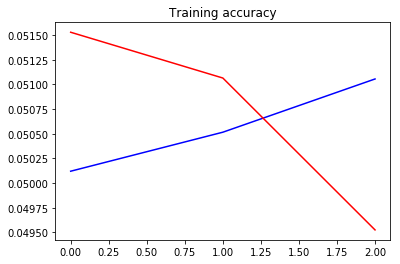

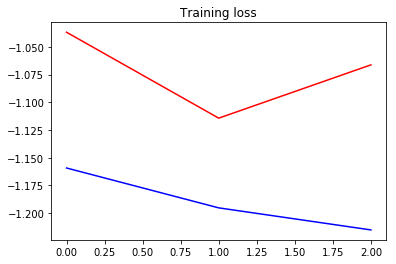

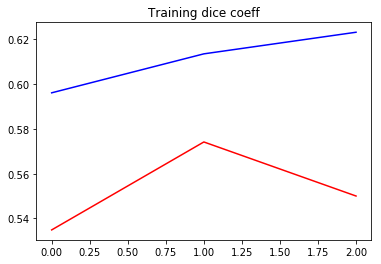

<Figure size 432x288 with 0 Axes>

In [44]:
plot_training(history)

In [50]:
# Let's use the best performing model so far:

model_256x1600 = load_model('./unet_model_256x1600_unsharp_4classes_v1_0.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

In [52]:
for idx in range(4, 96):
    layer_256x1600 = model_256x1600.get_layer(index=(idx + 7))
    layer_256x1600.trainable=True

In [57]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

{'name': 'conv2d_4', 'trainable': True, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [55]:
model_256x1600.compile(optimizer=RMSprop(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [58]:
PATIENCE = 2
EPOCHS = 5

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/5


 132/1419 [=>............................] - ETA: 40:04 - loss: -1.1586 - dice_coeff: 0.6028 - acc: 0.05 - ETA: 32:22 - loss: -0.9078 - dice_coeff: 0.4743 - acc: 0.03 - ETA: 30:11 - loss: -0.9116 - dice_coeff: 0.4713 - acc: 0.02 - ETA: 29:00 - loss: -1.0074 - dice_coeff: 0.5186 - acc: 0.03 - ETA: 28:00 - loss: -1.0655 - dice_coeff: 0.5527 - acc: 0.06 - ETA: 27:44 - loss: -1.0661 - dice_coeff: 0.5533 - acc: 0.05 - ETA: 27:21 - loss: -1.1391 - dice_coeff: 0.5878 - acc: 0.05 - ETA: 27:03 - loss: -1.1493 - dice_coeff: 0.5926 - acc: 0.05 - ETA: 26:44 - loss: -1.1664 - dice_coeff: 0.6004 - acc: 0.05 - ETA: 26:34 - loss: -1.1699 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 26:13 - loss: -1.1768 - dice_coeff: 0.6049 - acc: 0.05 - ETA: 25:40 - loss: -1.1969 - dice_coeff: 0.6150 - acc: 0.05 - ETA: 25:09 - loss: -1.1709 - dice_coeff: 0.6017 - acc: 0.05 - ETA: 24:45 - loss: -1.2139 - dice_coeff: 0.6225 - acc: 0.05 - ETA: 24:23 - loss: -1.1730 - dice_coeff: 0.6020 - acc: 0.05 - ETA: 23:59 - loss: -1.201

 264/1419 [====>.........................] - ETA: 18:42 - loss: -1.2023 - dice_coeff: 0.6173 - acc: 0.05 - ETA: 18:41 - loss: -1.2048 - dice_coeff: 0.6185 - acc: 0.05 - ETA: 18:41 - loss: -1.2030 - dice_coeff: 0.6177 - acc: 0.05 - ETA: 18:40 - loss: -1.2004 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 18:39 - loss: -1.2008 - dice_coeff: 0.6165 - acc: 0.05 - ETA: 18:39 - loss: -1.2001 - dice_coeff: 0.6162 - acc: 0.05 - ETA: 18:38 - loss: -1.2004 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 18:37 - loss: -1.1950 - dice_coeff: 0.6138 - acc: 0.05 - ETA: 18:35 - loss: -1.1900 - dice_coeff: 0.6115 - acc: 0.05 - ETA: 18:34 - loss: -1.1830 - dice_coeff: 0.6082 - acc: 0.05 - ETA: 18:33 - loss: -1.1869 - dice_coeff: 0.6101 - acc: 0.05 - ETA: 18:33 - loss: -1.1859 - dice_coeff: 0.6096 - acc: 0.05 - ETA: 18:31 - loss: -1.1878 - dice_coeff: 0.6105 - acc: 0.05 - ETA: 18:30 - loss: -1.1894 - dice_coeff: 0.6114 - acc: 0.05 - ETA: 18:29 - loss: -1.1889 - dice_coeff: 0.6112 - acc: 0.05 - ETA: 18:28 - loss: -1.189

 396/1419 [=======>......................] - ETA: 16:52 - loss: -1.1810 - dice_coeff: 0.6069 - acc: 0.05 - ETA: 16:51 - loss: -1.1806 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 16:50 - loss: -1.1817 - dice_coeff: 0.6073 - acc: 0.05 - ETA: 16:49 - loss: -1.1820 - dice_coeff: 0.6074 - acc: 0.05 - ETA: 16:48 - loss: -1.1824 - dice_coeff: 0.6076 - acc: 0.05 - ETA: 16:47 - loss: -1.1827 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 16:47 - loss: -1.1818 - dice_coeff: 0.6072 - acc: 0.05 - ETA: 16:46 - loss: -1.1823 - dice_coeff: 0.6074 - acc: 0.05 - ETA: 16:45 - loss: -1.1810 - dice_coeff: 0.6068 - acc: 0.05 - ETA: 16:44 - loss: -1.1816 - dice_coeff: 0.6071 - acc: 0.05 - ETA: 16:43 - loss: -1.1817 - dice_coeff: 0.6071 - acc: 0.04 - ETA: 16:43 - loss: -1.1817 - dice_coeff: 0.6071 - acc: 0.04 - ETA: 16:42 - loss: -1.1831 - dice_coeff: 0.6078 - acc: 0.04 - ETA: 16:41 - loss: -1.1799 - dice_coeff: 0.6062 - acc: 0.04 - ETA: 16:40 - loss: -1.1797 - dice_coeff: 0.6061 - acc: 0.04 - ETA: 16:39 - loss: -1.181

 528/1419 [==========>...................] - ETA: 14:57 - loss: -1.1826 - dice_coeff: 0.6075 - acc: 0.04 - ETA: 14:57 - loss: -1.1828 - dice_coeff: 0.6075 - acc: 0.04 - ETA: 14:56 - loss: -1.1819 - dice_coeff: 0.6071 - acc: 0.04 - ETA: 14:55 - loss: -1.1812 - dice_coeff: 0.6067 - acc: 0.04 - ETA: 14:54 - loss: -1.1821 - dice_coeff: 0.6072 - acc: 0.04 - ETA: 14:53 - loss: -1.1830 - dice_coeff: 0.6076 - acc: 0.04 - ETA: 14:52 - loss: -1.1832 - dice_coeff: 0.6077 - acc: 0.04 - ETA: 14:51 - loss: -1.1835 - dice_coeff: 0.6079 - acc: 0.04 - ETA: 14:51 - loss: -1.1833 - dice_coeff: 0.6078 - acc: 0.04 - ETA: 14:50 - loss: -1.1834 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 14:49 - loss: -1.1835 - dice_coeff: 0.6081 - acc: 0.05 - ETA: 14:48 - loss: -1.1838 - dice_coeff: 0.6082 - acc: 0.05 - ETA: 14:47 - loss: -1.1843 - dice_coeff: 0.6085 - acc: 0.05 - ETA: 14:46 - loss: -1.1849 - dice_coeff: 0.6088 - acc: 0.05 - ETA: 14:46 - loss: -1.1843 - dice_coeff: 0.6084 - acc: 0.05 - ETA: 14:45 - loss: -1.184

 660/1419 [============>.................] - ETA: 13:02 - loss: -1.1972 - dice_coeff: 0.6145 - acc: 0.05 - ETA: 13:01 - loss: -1.1965 - dice_coeff: 0.6141 - acc: 0.04 - ETA: 13:00 - loss: -1.1973 - dice_coeff: 0.6145 - acc: 0.04 - ETA: 13:00 - loss: -1.1977 - dice_coeff: 0.6147 - acc: 0.05 - ETA: 12:59 - loss: -1.1984 - dice_coeff: 0.6151 - acc: 0.05 - ETA: 12:58 - loss: -1.1991 - dice_coeff: 0.6154 - acc: 0.05 - ETA: 12:57 - loss: -1.1999 - dice_coeff: 0.6158 - acc: 0.05 - ETA: 12:56 - loss: -1.2003 - dice_coeff: 0.6160 - acc: 0.05 - ETA: 12:55 - loss: -1.2006 - dice_coeff: 0.6161 - acc: 0.05 - ETA: 12:54 - loss: -1.2001 - dice_coeff: 0.6158 - acc: 0.05 - ETA: 12:54 - loss: -1.2005 - dice_coeff: 0.6161 - acc: 0.05 - ETA: 12:53 - loss: -1.2004 - dice_coeff: 0.6160 - acc: 0.05 - ETA: 12:52 - loss: -1.2007 - dice_coeff: 0.6161 - acc: 0.05 - ETA: 12:51 - loss: -1.2013 - dice_coeff: 0.6164 - acc: 0.05 - ETA: 12:50 - loss: -1.2014 - dice_coeff: 0.6165 - acc: 0.05 - ETA: 12:49 - loss: -1.199

 792/1419 [===============>..............] - ETA: 11:06 - loss: -1.2116 - dice_coeff: 0.6217 - acc: 0.05 - ETA: 11:05 - loss: -1.2117 - dice_coeff: 0.6218 - acc: 0.05 - ETA: 11:05 - loss: -1.2114 - dice_coeff: 0.6216 - acc: 0.05 - ETA: 11:04 - loss: -1.2117 - dice_coeff: 0.6217 - acc: 0.05 - ETA: 11:03 - loss: -1.2113 - dice_coeff: 0.6216 - acc: 0.05 - ETA: 11:02 - loss: -1.2116 - dice_coeff: 0.6218 - acc: 0.05 - ETA: 11:01 - loss: -1.2120 - dice_coeff: 0.6219 - acc: 0.05 - ETA: 11:00 - loss: -1.2114 - dice_coeff: 0.6216 - acc: 0.05 - ETA: 10:59 - loss: -1.2103 - dice_coeff: 0.6212 - acc: 0.05 - ETA: 10:58 - loss: -1.2109 - dice_coeff: 0.6214 - acc: 0.05 - ETA: 10:57 - loss: -1.2112 - dice_coeff: 0.6216 - acc: 0.05 - ETA: 10:57 - loss: -1.2113 - dice_coeff: 0.6216 - acc: 0.05 - ETA: 10:56 - loss: -1.2114 - dice_coeff: 0.6217 - acc: 0.05 - ETA: 10:55 - loss: -1.2118 - dice_coeff: 0.6219 - acc: 0.05 - ETA: 10:54 - loss: -1.2115 - dice_coeff: 0.6217 - acc: 0.05 - ETA: 10:53 - loss: -1.211

 924/1419 [==================>...........] - ETA: 9:10 - loss: -1.2072 - dice_coeff: 0.6196 - acc: 0.051 - ETA: 9:09 - loss: -1.2076 - dice_coeff: 0.6198 - acc: 0.051 - ETA: 9:08 - loss: -1.2075 - dice_coeff: 0.6197 - acc: 0.051 - ETA: 9:07 - loss: -1.2076 - dice_coeff: 0.6198 - acc: 0.051 - ETA: 9:07 - loss: -1.2078 - dice_coeff: 0.6198 - acc: 0.051 - ETA: 9:06 - loss: -1.2072 - dice_coeff: 0.6196 - acc: 0.051 - ETA: 9:05 - loss: -1.2072 - dice_coeff: 0.6196 - acc: 0.051 - ETA: 9:04 - loss: -1.2076 - dice_coeff: 0.6198 - acc: 0.051 - ETA: 9:03 - loss: -1.2072 - dice_coeff: 0.6196 - acc: 0.051 - ETA: 9:02 - loss: -1.2076 - dice_coeff: 0.6198 - acc: 0.051 - ETA: 9:01 - loss: -1.2074 - dice_coeff: 0.6197 - acc: 0.051 - ETA: 9:01 - loss: -1.2074 - dice_coeff: 0.6197 - acc: 0.051 - ETA: 9:00 - loss: -1.2071 - dice_coeff: 0.6195 - acc: 0.051 - ETA: 8:59 - loss: -1.2063 - dice_coeff: 0.6192 - acc: 0.051 - ETA: 8:58 - loss: -1.2061 - dice_coeff: 0.6191 - acc: 0.051 - ETA: 8:57 - loss: -1.2061

1056/1419 [=====================>........] - ETA: 7:14 - loss: -1.2000 - dice_coeff: 0.6158 - acc: 0.050 - ETA: 7:13 - loss: -1.2004 - dice_coeff: 0.6160 - acc: 0.050 - ETA: 7:12 - loss: -1.2009 - dice_coeff: 0.6162 - acc: 0.050 - ETA: 7:11 - loss: -1.2006 - dice_coeff: 0.6161 - acc: 0.050 - ETA: 7:10 - loss: -1.2009 - dice_coeff: 0.6163 - acc: 0.050 - ETA: 7:09 - loss: -1.2013 - dice_coeff: 0.6164 - acc: 0.050 - ETA: 7:08 - loss: -1.2011 - dice_coeff: 0.6164 - acc: 0.050 - ETA: 7:08 - loss: -1.2010 - dice_coeff: 0.6163 - acc: 0.050 - ETA: 7:07 - loss: -1.2015 - dice_coeff: 0.6165 - acc: 0.050 - ETA: 7:06 - loss: -1.2013 - dice_coeff: 0.6164 - acc: 0.050 - ETA: 7:05 - loss: -1.2019 - dice_coeff: 0.6167 - acc: 0.050 - ETA: 7:04 - loss: -1.2019 - dice_coeff: 0.6167 - acc: 0.050 - ETA: 7:03 - loss: -1.2020 - dice_coeff: 0.6168 - acc: 0.050 - ETA: 7:02 - loss: -1.2017 - dice_coeff: 0.6167 - acc: 0.050 - ETA: 7:01 - loss: -1.2014 - dice_coeff: 0.6165 - acc: 0.050 - ETA: 7:00 - loss: -1.2009

1188/1419 [========================>.....] - ETA: 5:17 - loss: -1.2050 - dice_coeff: 0.6183 - acc: 0.050 - ETA: 5:16 - loss: -1.2051 - dice_coeff: 0.6183 - acc: 0.050 - ETA: 5:16 - loss: -1.2043 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:15 - loss: -1.2043 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:14 - loss: -1.2042 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:13 - loss: -1.2041 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:12 - loss: -1.2042 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:11 - loss: -1.2036 - dice_coeff: 0.6176 - acc: 0.050 - ETA: 5:10 - loss: -1.2038 - dice_coeff: 0.6177 - acc: 0.050 - ETA: 5:09 - loss: -1.2041 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:08 - loss: -1.2042 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:08 - loss: -1.2043 - dice_coeff: 0.6180 - acc: 0.050 - ETA: 5:07 - loss: -1.2042 - dice_coeff: 0.6179 - acc: 0.050 - ETA: 5:06 - loss: -1.2045 - dice_coeff: 0.6181 - acc: 0.050 - ETA: 5:05 - loss: -1.2046 - dice_coeff: 0.6181 - acc: 0.050 - ETA: 5:04 - loss: -1.2047

1320/1419 [==========================>...] - ETA: 3:21 - loss: -1.2023 - dice_coeff: 0.6170 - acc: 0.051 - ETA: 3:21 - loss: -1.2023 - dice_coeff: 0.6170 - acc: 0.051 - ETA: 3:20 - loss: -1.2019 - dice_coeff: 0.6168 - acc: 0.050 - ETA: 3:19 - loss: -1.2024 - dice_coeff: 0.6170 - acc: 0.051 - ETA: 3:18 - loss: -1.2026 - dice_coeff: 0.6171 - acc: 0.050 - ETA: 3:17 - loss: -1.2028 - dice_coeff: 0.6172 - acc: 0.050 - ETA: 3:16 - loss: -1.2030 - dice_coeff: 0.6173 - acc: 0.050 - ETA: 3:15 - loss: -1.2032 - dice_coeff: 0.6174 - acc: 0.051 - ETA: 3:14 - loss: -1.2032 - dice_coeff: 0.6174 - acc: 0.051 - ETA: 3:14 - loss: -1.2034 - dice_coeff: 0.6175 - acc: 0.051 - ETA: 3:13 - loss: -1.2030 - dice_coeff: 0.6173 - acc: 0.051 - ETA: 3:12 - loss: -1.2031 - dice_coeff: 0.6173 - acc: 0.051 - ETA: 3:11 - loss: -1.2033 - dice_coeff: 0.6175 - acc: 0.051 - ETA: 3:10 - loss: -1.2034 - dice_coeff: 0.6175 - acc: 0.051 - ETA: 3:09 - loss: -1.2032 - dice_coeff: 0.6174 - acc: 0.051 - ETA: 3:08 - loss: -1.2034

1419/1419 [==============================] - ETA: 1:26 - loss: -1.2079 - dice_coeff: 0.6196 - acc: 0.050 - ETA: 1:25 - loss: -1.2083 - dice_coeff: 0.6198 - acc: 0.050 - ETA: 1:24 - loss: -1.2080 - dice_coeff: 0.6197 - acc: 0.050 - ETA: 1:23 - loss: -1.2083 - dice_coeff: 0.6198 - acc: 0.050 - ETA: 1:22 - loss: -1.2087 - dice_coeff: 0.6200 - acc: 0.050 - ETA: 1:21 - loss: -1.2088 - dice_coeff: 0.6201 - acc: 0.050 - ETA: 1:20 - loss: -1.2090 - dice_coeff: 0.6201 - acc: 0.050 - ETA: 1:19 - loss: -1.2091 - dice_coeff: 0.6202 - acc: 0.050 - ETA: 1:18 - loss: -1.2091 - dice_coeff: 0.6202 - acc: 0.050 - ETA: 1:18 - loss: -1.2094 - dice_coeff: 0.6203 - acc: 0.050 - ETA: 1:17 - loss: -1.2086 - dice_coeff: 0.6200 - acc: 0.050 - ETA: 1:16 - loss: -1.2088 - dice_coeff: 0.6201 - acc: 0.050 - ETA: 1:15 - loss: -1.2091 - dice_coeff: 0.6202 - acc: 0.050 - ETA: 1:14 - loss: -1.2092 - dice_coeff: 0.6202 - acc: 0.050 - ETA: 1:13 - loss: -1.2092 - dice_coeff: 0.6202 - acc: 0.050 - ETA: 1:12 - loss: -1.2095

 132/1419 [=>............................] - ETA: 15:15 - loss: -1.5433 - dice_coeff: 0.7921 - acc: 0.21 - ETA: 15:22 - loss: -1.5365 - dice_coeff: 0.7892 - acc: 0.16 - ETA: 15:17 - loss: -1.4138 - dice_coeff: 0.7266 - acc: 0.13 - ETA: 15:25 - loss: -1.4739 - dice_coeff: 0.7536 - acc: 0.11 - ETA: 15:22 - loss: -1.4575 - dice_coeff: 0.7444 - acc: 0.10 - ETA: 15:26 - loss: -1.4023 - dice_coeff: 0.7181 - acc: 0.09 - ETA: 15:23 - loss: -1.2695 - dice_coeff: 0.6541 - acc: 0.09 - ETA: 15:35 - loss: -1.3258 - dice_coeff: 0.6813 - acc: 0.09 - ETA: 15:35 - loss: -1.3320 - dice_coeff: 0.6839 - acc: 0.09 - ETA: 15:32 - loss: -1.2927 - dice_coeff: 0.6652 - acc: 0.08 - ETA: 15:29 - loss: -1.2806 - dice_coeff: 0.6581 - acc: 0.08 - ETA: 15:27 - loss: -1.2776 - dice_coeff: 0.6566 - acc: 0.08 - ETA: 15:26 - loss: -1.2472 - dice_coeff: 0.6426 - acc: 0.08 - ETA: 15:23 - loss: -1.1947 - dice_coeff: 0.6156 - acc: 0.07 - ETA: 15:23 - loss: -1.2145 - dice_coeff: 0.6258 - acc: 0.07 - ETA: 15:22 - loss: -1.212

 264/1419 [====>.........................] - ETA: 17:48 - loss: -1.2753 - dice_coeff: 0.6534 - acc: 0.05 - ETA: 17:52 - loss: -1.2759 - dice_coeff: 0.6537 - acc: 0.05 - ETA: 17:52 - loss: -1.2781 - dice_coeff: 0.6548 - acc: 0.05 - ETA: 17:51 - loss: -1.2719 - dice_coeff: 0.6517 - acc: 0.05 - ETA: 17:51 - loss: -1.2728 - dice_coeff: 0.6521 - acc: 0.05 - ETA: 17:51 - loss: -1.2730 - dice_coeff: 0.6521 - acc: 0.05 - ETA: 17:50 - loss: -1.2747 - dice_coeff: 0.6529 - acc: 0.05 - ETA: 17:50 - loss: -1.2762 - dice_coeff: 0.6536 - acc: 0.05 - ETA: 17:49 - loss: -1.2744 - dice_coeff: 0.6526 - acc: 0.05 - ETA: 17:49 - loss: -1.2714 - dice_coeff: 0.6511 - acc: 0.05 - ETA: 17:49 - loss: -1.2736 - dice_coeff: 0.6522 - acc: 0.05 - ETA: 17:49 - loss: -1.2738 - dice_coeff: 0.6523 - acc: 0.05 - ETA: 17:48 - loss: -1.2719 - dice_coeff: 0.6513 - acc: 0.05 - ETA: 17:48 - loss: -1.2681 - dice_coeff: 0.6496 - acc: 0.05 - ETA: 17:47 - loss: -1.2702 - dice_coeff: 0.6506 - acc: 0.05 - ETA: 17:46 - loss: -1.268

 396/1419 [=======>......................] - ETA: 16:23 - loss: -1.2730 - dice_coeff: 0.6516 - acc: 0.05 - ETA: 16:23 - loss: -1.2734 - dice_coeff: 0.6517 - acc: 0.05 - ETA: 16:22 - loss: -1.2729 - dice_coeff: 0.6515 - acc: 0.05 - ETA: 16:21 - loss: -1.2724 - dice_coeff: 0.6512 - acc: 0.05 - ETA: 16:20 - loss: -1.2731 - dice_coeff: 0.6515 - acc: 0.05 - ETA: 16:19 - loss: -1.2734 - dice_coeff: 0.6517 - acc: 0.05 - ETA: 16:18 - loss: -1.2725 - dice_coeff: 0.6513 - acc: 0.05 - ETA: 16:17 - loss: -1.2706 - dice_coeff: 0.6503 - acc: 0.05 - ETA: 16:16 - loss: -1.2713 - dice_coeff: 0.6506 - acc: 0.05 - ETA: 16:15 - loss: -1.2717 - dice_coeff: 0.6508 - acc: 0.05 - ETA: 16:15 - loss: -1.2721 - dice_coeff: 0.6510 - acc: 0.05 - ETA: 16:14 - loss: -1.2725 - dice_coeff: 0.6512 - acc: 0.05 - ETA: 16:13 - loss: -1.2740 - dice_coeff: 0.6519 - acc: 0.05 - ETA: 16:12 - loss: -1.2738 - dice_coeff: 0.6518 - acc: 0.05 - ETA: 16:12 - loss: -1.2745 - dice_coeff: 0.6521 - acc: 0.05 - ETA: 16:11 - loss: -1.273

 528/1419 [==========>...................] - ETA: 14:35 - loss: -1.2759 - dice_coeff: 0.6526 - acc: 0.05 - ETA: 14:34 - loss: -1.2764 - dice_coeff: 0.6528 - acc: 0.05 - ETA: 14:33 - loss: -1.2759 - dice_coeff: 0.6526 - acc: 0.05 - ETA: 14:33 - loss: -1.2761 - dice_coeff: 0.6527 - acc: 0.05 - ETA: 14:32 - loss: -1.2770 - dice_coeff: 0.6531 - acc: 0.05 - ETA: 14:31 - loss: -1.2758 - dice_coeff: 0.6525 - acc: 0.05 - ETA: 14:30 - loss: -1.2754 - dice_coeff: 0.6523 - acc: 0.05 - ETA: 14:29 - loss: -1.2755 - dice_coeff: 0.6524 - acc: 0.05 - ETA: 14:28 - loss: -1.2751 - dice_coeff: 0.6522 - acc: 0.05 - ETA: 14:27 - loss: -1.2753 - dice_coeff: 0.6523 - acc: 0.05 - ETA: 14:27 - loss: -1.2745 - dice_coeff: 0.6520 - acc: 0.05 - ETA: 14:26 - loss: -1.2755 - dice_coeff: 0.6524 - acc: 0.05 - ETA: 14:25 - loss: -1.2767 - dice_coeff: 0.6530 - acc: 0.05 - ETA: 14:24 - loss: -1.2775 - dice_coeff: 0.6534 - acc: 0.05 - ETA: 14:25 - loss: -1.2778 - dice_coeff: 0.6536 - acc: 0.05 - ETA: 14:24 - loss: -1.278

 660/1419 [============>.................] - ETA: 12:46 - loss: -1.2702 - dice_coeff: 0.6499 - acc: 0.05 - ETA: 12:46 - loss: -1.2707 - dice_coeff: 0.6502 - acc: 0.05 - ETA: 12:45 - loss: -1.2702 - dice_coeff: 0.6499 - acc: 0.05 - ETA: 12:44 - loss: -1.2701 - dice_coeff: 0.6498 - acc: 0.05 - ETA: 12:43 - loss: -1.2706 - dice_coeff: 0.6501 - acc: 0.05 - ETA: 12:42 - loss: -1.2706 - dice_coeff: 0.6501 - acc: 0.05 - ETA: 12:41 - loss: -1.2711 - dice_coeff: 0.6503 - acc: 0.05 - ETA: 12:40 - loss: -1.2711 - dice_coeff: 0.6504 - acc: 0.05 - ETA: 12:40 - loss: -1.2710 - dice_coeff: 0.6503 - acc: 0.05 - ETA: 12:39 - loss: -1.2711 - dice_coeff: 0.6503 - acc: 0.05 - ETA: 12:38 - loss: -1.2709 - dice_coeff: 0.6502 - acc: 0.05 - ETA: 12:37 - loss: -1.2712 - dice_coeff: 0.6504 - acc: 0.05 - ETA: 12:36 - loss: -1.2709 - dice_coeff: 0.6502 - acc: 0.05 - ETA: 12:35 - loss: -1.2707 - dice_coeff: 0.6501 - acc: 0.05 - ETA: 12:35 - loss: -1.2694 - dice_coeff: 0.6495 - acc: 0.05 - ETA: 12:34 - loss: -1.269

 792/1419 [===============>..............] - ETA: 10:54 - loss: -1.2606 - dice_coeff: 0.6451 - acc: 0.05 - ETA: 10:53 - loss: -1.2605 - dice_coeff: 0.6451 - acc: 0.05 - ETA: 10:52 - loss: -1.2607 - dice_coeff: 0.6452 - acc: 0.05 - ETA: 10:51 - loss: -1.2607 - dice_coeff: 0.6452 - acc: 0.05 - ETA: 10:51 - loss: -1.2610 - dice_coeff: 0.6453 - acc: 0.05 - ETA: 10:50 - loss: -1.2611 - dice_coeff: 0.6454 - acc: 0.05 - ETA: 10:49 - loss: -1.2606 - dice_coeff: 0.6451 - acc: 0.05 - ETA: 10:48 - loss: -1.2610 - dice_coeff: 0.6453 - acc: 0.05 - ETA: 10:47 - loss: -1.2611 - dice_coeff: 0.6453 - acc: 0.05 - ETA: 10:46 - loss: -1.2600 - dice_coeff: 0.6448 - acc: 0.05 - ETA: 10:45 - loss: -1.2599 - dice_coeff: 0.6447 - acc: 0.05 - ETA: 10:44 - loss: -1.2601 - dice_coeff: 0.6448 - acc: 0.05 - ETA: 10:44 - loss: -1.2597 - dice_coeff: 0.6446 - acc: 0.05 - ETA: 10:43 - loss: -1.2603 - dice_coeff: 0.6449 - acc: 0.05 - ETA: 10:42 - loss: -1.2599 - dice_coeff: 0.6448 - acc: 0.05 - ETA: 10:41 - loss: -1.258

 924/1419 [==================>...........] - ETA: 9:01 - loss: -1.2536 - dice_coeff: 0.6418 - acc: 0.052 - ETA: 9:00 - loss: -1.2525 - dice_coeff: 0.6413 - acc: 0.052 - ETA: 9:00 - loss: -1.2529 - dice_coeff: 0.6415 - acc: 0.052 - ETA: 8:59 - loss: -1.2528 - dice_coeff: 0.6414 - acc: 0.052 - ETA: 8:58 - loss: -1.2531 - dice_coeff: 0.6416 - acc: 0.052 - ETA: 8:57 - loss: -1.2526 - dice_coeff: 0.6415 - acc: 0.052 - ETA: 8:56 - loss: -1.2531 - dice_coeff: 0.6417 - acc: 0.052 - ETA: 8:55 - loss: -1.2537 - dice_coeff: 0.6420 - acc: 0.052 - ETA: 8:54 - loss: -1.2529 - dice_coeff: 0.6416 - acc: 0.052 - ETA: 8:54 - loss: -1.2525 - dice_coeff: 0.6414 - acc: 0.052 - ETA: 8:53 - loss: -1.2517 - dice_coeff: 0.6410 - acc: 0.052 - ETA: 8:52 - loss: -1.2520 - dice_coeff: 0.6411 - acc: 0.052 - ETA: 8:51 - loss: -1.2525 - dice_coeff: 0.6413 - acc: 0.052 - ETA: 8:50 - loss: -1.2529 - dice_coeff: 0.6415 - acc: 0.052 - ETA: 8:49 - loss: -1.2524 - dice_coeff: 0.6413 - acc: 0.052 - ETA: 8:48 - loss: -1.2522

1056/1419 [=====================>........] - ETA: 7:08 - loss: -1.2486 - dice_coeff: 0.6393 - acc: 0.052 - ETA: 7:07 - loss: -1.2488 - dice_coeff: 0.6394 - acc: 0.052 - ETA: 7:06 - loss: -1.2486 - dice_coeff: 0.6393 - acc: 0.052 - ETA: 7:05 - loss: -1.2489 - dice_coeff: 0.6394 - acc: 0.052 - ETA: 7:04 - loss: -1.2487 - dice_coeff: 0.6393 - acc: 0.052 - ETA: 7:03 - loss: -1.2485 - dice_coeff: 0.6393 - acc: 0.052 - ETA: 7:03 - loss: -1.2488 - dice_coeff: 0.6394 - acc: 0.052 - ETA: 7:02 - loss: -1.2490 - dice_coeff: 0.6395 - acc: 0.052 - ETA: 7:01 - loss: -1.2488 - dice_coeff: 0.6394 - acc: 0.052 - ETA: 7:00 - loss: -1.2488 - dice_coeff: 0.6394 - acc: 0.051 - ETA: 6:59 - loss: -1.2492 - dice_coeff: 0.6396 - acc: 0.051 - ETA: 6:58 - loss: -1.2494 - dice_coeff: 0.6396 - acc: 0.051 - ETA: 6:57 - loss: -1.2492 - dice_coeff: 0.6396 - acc: 0.051 - ETA: 6:57 - loss: -1.2491 - dice_coeff: 0.6395 - acc: 0.051 - ETA: 6:56 - loss: -1.2492 - dice_coeff: 0.6396 - acc: 0.051 - ETA: 6:55 - loss: -1.2494

1188/1419 [========================>.....] - ETA: 5:14 - loss: -1.2468 - dice_coeff: 0.6384 - acc: 0.051 - ETA: 5:13 - loss: -1.2466 - dice_coeff: 0.6383 - acc: 0.051 - ETA: 5:12 - loss: -1.2461 - dice_coeff: 0.6381 - acc: 0.051 - ETA: 5:11 - loss: -1.2465 - dice_coeff: 0.6382 - acc: 0.051 - ETA: 5:10 - loss: -1.2459 - dice_coeff: 0.6379 - acc: 0.051 - ETA: 5:09 - loss: -1.2460 - dice_coeff: 0.6380 - acc: 0.051 - ETA: 5:09 - loss: -1.2463 - dice_coeff: 0.6381 - acc: 0.052 - ETA: 5:08 - loss: -1.2461 - dice_coeff: 0.6380 - acc: 0.051 - ETA: 5:07 - loss: -1.2455 - dice_coeff: 0.6378 - acc: 0.052 - ETA: 5:06 - loss: -1.2458 - dice_coeff: 0.6379 - acc: 0.052 - ETA: 5:05 - loss: -1.2461 - dice_coeff: 0.6381 - acc: 0.052 - ETA: 5:04 - loss: -1.2465 - dice_coeff: 0.6383 - acc: 0.052 - ETA: 5:03 - loss: -1.2464 - dice_coeff: 0.6382 - acc: 0.052 - ETA: 5:02 - loss: -1.2466 - dice_coeff: 0.6383 - acc: 0.052 - ETA: 5:02 - loss: -1.2469 - dice_coeff: 0.6385 - acc: 0.052 - ETA: 5:01 - loss: -1.2470

1320/1419 [==========================>...] - ETA: 3:19 - loss: -1.2406 - dice_coeff: 0.6353 - acc: 0.051 - ETA: 3:18 - loss: -1.2402 - dice_coeff: 0.6351 - acc: 0.051 - ETA: 3:17 - loss: -1.2399 - dice_coeff: 0.6350 - acc: 0.051 - ETA: 3:17 - loss: -1.2402 - dice_coeff: 0.6351 - acc: 0.051 - ETA: 3:16 - loss: -1.2401 - dice_coeff: 0.6350 - acc: 0.051 - ETA: 3:15 - loss: -1.2398 - dice_coeff: 0.6349 - acc: 0.051 - ETA: 3:14 - loss: -1.2400 - dice_coeff: 0.6350 - acc: 0.051 - ETA: 3:13 - loss: -1.2398 - dice_coeff: 0.6349 - acc: 0.051 - ETA: 3:12 - loss: -1.2401 - dice_coeff: 0.6351 - acc: 0.051 - ETA: 3:11 - loss: -1.2404 - dice_coeff: 0.6352 - acc: 0.051 - ETA: 3:11 - loss: -1.2407 - dice_coeff: 0.6354 - acc: 0.051 - ETA: 3:10 - loss: -1.2406 - dice_coeff: 0.6353 - acc: 0.051 - ETA: 3:09 - loss: -1.2408 - dice_coeff: 0.6354 - acc: 0.051 - ETA: 3:08 - loss: -1.2409 - dice_coeff: 0.6354 - acc: 0.051 - ETA: 3:07 - loss: -1.2407 - dice_coeff: 0.6354 - acc: 0.051 - ETA: 3:06 - loss: -1.2407

1419/1419 [==============================] - ETA: 1:25 - loss: -1.2369 - dice_coeff: 0.6336 - acc: 0.051 - ETA: 1:24 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:23 - loss: -1.2369 - dice_coeff: 0.6336 - acc: 0.051 - ETA: 1:22 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:21 - loss: -1.2366 - dice_coeff: 0.6334 - acc: 0.051 - ETA: 1:20 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:19 - loss: -1.2366 - dice_coeff: 0.6334 - acc: 0.051 - ETA: 1:19 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:18 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:17 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:16 - loss: -1.2367 - dice_coeff: 0.6334 - acc: 0.051 - ETA: 1:15 - loss: -1.2367 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:14 - loss: -1.2368 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:13 - loss: -1.2369 - dice_coeff: 0.6336 - acc: 0.051 - ETA: 1:12 - loss: -1.2368 - dice_coeff: 0.6335 - acc: 0.051 - ETA: 1:12 - loss: -1.2366

 132/1419 [=>............................] - ETA: 15:16 - loss: -1.7241 - dice_coeff: 0.8655 - acc: 0.03 - ETA: 15:25 - loss: -1.2275 - dice_coeff: 0.6226 - acc: 0.02 - ETA: 15:28 - loss: -1.3851 - dice_coeff: 0.6995 - acc: 0.02 - ETA: 15:22 - loss: -1.4513 - dice_coeff: 0.7330 - acc: 0.04 - ETA: 15:23 - loss: -1.4298 - dice_coeff: 0.7223 - acc: 0.03 - ETA: 15:24 - loss: -1.4112 - dice_coeff: 0.7152 - acc: 0.04 - ETA: 15:26 - loss: -1.3899 - dice_coeff: 0.7063 - acc: 0.05 - ETA: 15:27 - loss: -1.3970 - dice_coeff: 0.7127 - acc: 0.07 - ETA: 15:26 - loss: -1.3084 - dice_coeff: 0.6713 - acc: 0.07 - ETA: 15:28 - loss: -1.2928 - dice_coeff: 0.6639 - acc: 0.07 - ETA: 15:27 - loss: -1.2335 - dice_coeff: 0.6350 - acc: 0.07 - ETA: 15:23 - loss: -1.2059 - dice_coeff: 0.6240 - acc: 0.07 - ETA: 15:23 - loss: -1.1735 - dice_coeff: 0.6072 - acc: 0.07 - ETA: 15:21 - loss: -1.1389 - dice_coeff: 0.5896 - acc: 0.06 - ETA: 15:20 - loss: -1.1601 - dice_coeff: 0.5992 - acc: 0.06 - ETA: 15:20 - loss: -1.171

 264/1419 [====>.........................] - ETA: 17:39 - loss: -1.2530 - dice_coeff: 0.6399 - acc: 0.04 - ETA: 17:40 - loss: -1.2522 - dice_coeff: 0.6394 - acc: 0.04 - ETA: 17:39 - loss: -1.2549 - dice_coeff: 0.6407 - acc: 0.04 - ETA: 17:39 - loss: -1.2557 - dice_coeff: 0.6413 - acc: 0.04 - ETA: 17:39 - loss: -1.2584 - dice_coeff: 0.6426 - acc: 0.04 - ETA: 17:40 - loss: -1.2609 - dice_coeff: 0.6438 - acc: 0.04 - ETA: 17:38 - loss: -1.2621 - dice_coeff: 0.6443 - acc: 0.04 - ETA: 17:38 - loss: -1.2628 - dice_coeff: 0.6446 - acc: 0.04 - ETA: 17:37 - loss: -1.2651 - dice_coeff: 0.6457 - acc: 0.04 - ETA: 17:36 - loss: -1.2657 - dice_coeff: 0.6460 - acc: 0.04 - ETA: 17:36 - loss: -1.2651 - dice_coeff: 0.6457 - acc: 0.04 - ETA: 17:35 - loss: -1.2662 - dice_coeff: 0.6462 - acc: 0.04 - ETA: 17:35 - loss: -1.2682 - dice_coeff: 0.6472 - acc: 0.04 - ETA: 17:34 - loss: -1.2666 - dice_coeff: 0.6464 - acc: 0.04 - ETA: 17:34 - loss: -1.2690 - dice_coeff: 0.6476 - acc: 0.04 - ETA: 17:33 - loss: -1.263

 396/1419 [=======>......................] - ETA: 16:18 - loss: -1.2479 - dice_coeff: 0.6377 - acc: 0.04 - ETA: 16:17 - loss: -1.2491 - dice_coeff: 0.6383 - acc: 0.04 - ETA: 16:16 - loss: -1.2499 - dice_coeff: 0.6387 - acc: 0.04 - ETA: 16:16 - loss: -1.2495 - dice_coeff: 0.6385 - acc: 0.04 - ETA: 16:15 - loss: -1.2500 - dice_coeff: 0.6387 - acc: 0.04 - ETA: 16:16 - loss: -1.2516 - dice_coeff: 0.6395 - acc: 0.04 - ETA: 16:16 - loss: -1.2531 - dice_coeff: 0.6402 - acc: 0.04 - ETA: 16:15 - loss: -1.2542 - dice_coeff: 0.6408 - acc: 0.04 - ETA: 16:14 - loss: -1.2533 - dice_coeff: 0.6403 - acc: 0.04 - ETA: 16:13 - loss: -1.2537 - dice_coeff: 0.6405 - acc: 0.04 - ETA: 16:12 - loss: -1.2535 - dice_coeff: 0.6406 - acc: 0.04 - ETA: 16:12 - loss: -1.2519 - dice_coeff: 0.6398 - acc: 0.04 - ETA: 16:11 - loss: -1.2519 - dice_coeff: 0.6398 - acc: 0.04 - ETA: 16:10 - loss: -1.2530 - dice_coeff: 0.6404 - acc: 0.04 - ETA: 16:09 - loss: -1.2537 - dice_coeff: 0.6407 - acc: 0.04 - ETA: 16:08 - loss: -1.255

 528/1419 [==========>...................] - ETA: 14:37 - loss: -1.2520 - dice_coeff: 0.6402 - acc: 0.05 - ETA: 14:36 - loss: -1.2532 - dice_coeff: 0.6408 - acc: 0.05 - ETA: 14:36 - loss: -1.2525 - dice_coeff: 0.6405 - acc: 0.05 - ETA: 14:35 - loss: -1.2519 - dice_coeff: 0.6403 - acc: 0.05 - ETA: 14:34 - loss: -1.2528 - dice_coeff: 0.6408 - acc: 0.05 - ETA: 14:33 - loss: -1.2534 - dice_coeff: 0.6410 - acc: 0.05 - ETA: 14:32 - loss: -1.2540 - dice_coeff: 0.6413 - acc: 0.05 - ETA: 14:31 - loss: -1.2536 - dice_coeff: 0.6411 - acc: 0.05 - ETA: 14:30 - loss: -1.2531 - dice_coeff: 0.6409 - acc: 0.05 - ETA: 14:30 - loss: -1.2536 - dice_coeff: 0.6411 - acc: 0.05 - ETA: 14:29 - loss: -1.2530 - dice_coeff: 0.6409 - acc: 0.05 - ETA: 14:28 - loss: -1.2533 - dice_coeff: 0.6410 - acc: 0.05 - ETA: 14:27 - loss: -1.2524 - dice_coeff: 0.6406 - acc: 0.05 - ETA: 14:26 - loss: -1.2530 - dice_coeff: 0.6408 - acc: 0.05 - ETA: 14:25 - loss: -1.2523 - dice_coeff: 0.6405 - acc: 0.05 - ETA: 14:25 - loss: -1.251

 660/1419 [============>.................] - ETA: 12:47 - loss: -1.2534 - dice_coeff: 0.6412 - acc: 0.05 - ETA: 12:46 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.05 - ETA: 12:45 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.05 - ETA: 12:44 - loss: -1.2535 - dice_coeff: 0.6413 - acc: 0.05 - ETA: 12:43 - loss: -1.2534 - dice_coeff: 0.6412 - acc: 0.05 - ETA: 12:42 - loss: -1.2532 - dice_coeff: 0.6412 - acc: 0.05 - ETA: 12:41 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.05 - ETA: 12:40 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.05 - ETA: 12:40 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.05 - ETA: 12:39 - loss: -1.2532 - dice_coeff: 0.6411 - acc: 0.05 - ETA: 12:38 - loss: -1.2519 - dice_coeff: 0.6405 - acc: 0.05 - ETA: 12:37 - loss: -1.2503 - dice_coeff: 0.6396 - acc: 0.05 - ETA: 12:36 - loss: -1.2507 - dice_coeff: 0.6398 - acc: 0.05 - ETA: 12:36 - loss: -1.2507 - dice_coeff: 0.6398 - acc: 0.05 - ETA: 12:35 - loss: -1.2508 - dice_coeff: 0.6399 - acc: 0.05 - ETA: 12:34 - loss: -1.251

 792/1419 [===============>..............] - ETA: 10:56 - loss: -1.2577 - dice_coeff: 0.6434 - acc: 0.05 - ETA: 10:55 - loss: -1.2586 - dice_coeff: 0.6438 - acc: 0.05 - ETA: 10:54 - loss: -1.2578 - dice_coeff: 0.6435 - acc: 0.05 - ETA: 10:53 - loss: -1.2576 - dice_coeff: 0.6434 - acc: 0.05 - ETA: 10:52 - loss: -1.2583 - dice_coeff: 0.6437 - acc: 0.05 - ETA: 10:52 - loss: -1.2585 - dice_coeff: 0.6438 - acc: 0.05 - ETA: 10:51 - loss: -1.2587 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:50 - loss: -1.2588 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:49 - loss: -1.2591 - dice_coeff: 0.6440 - acc: 0.05 - ETA: 10:48 - loss: -1.2588 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:47 - loss: -1.2589 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:46 - loss: -1.2593 - dice_coeff: 0.6441 - acc: 0.05 - ETA: 10:46 - loss: -1.2588 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:45 - loss: -1.2588 - dice_coeff: 0.6439 - acc: 0.05 - ETA: 10:44 - loss: -1.2580 - dice_coeff: 0.6435 - acc: 0.05 - ETA: 10:43 - loss: -1.256

 924/1419 [==================>...........] - ETA: 9:02 - loss: -1.2602 - dice_coeff: 0.6446 - acc: 0.054 - ETA: 9:01 - loss: -1.2603 - dice_coeff: 0.6446 - acc: 0.054 - ETA: 9:00 - loss: -1.2606 - dice_coeff: 0.6448 - acc: 0.054 - ETA: 9:00 - loss: -1.2605 - dice_coeff: 0.6447 - acc: 0.054 - ETA: 8:59 - loss: -1.2596 - dice_coeff: 0.6442 - acc: 0.054 - ETA: 8:58 - loss: -1.2602 - dice_coeff: 0.6445 - acc: 0.054 - ETA: 8:57 - loss: -1.2593 - dice_coeff: 0.6440 - acc: 0.054 - ETA: 8:56 - loss: -1.2587 - dice_coeff: 0.6438 - acc: 0.054 - ETA: 8:55 - loss: -1.2589 - dice_coeff: 0.6439 - acc: 0.054 - ETA: 8:54 - loss: -1.2594 - dice_coeff: 0.6441 - acc: 0.054 - ETA: 8:54 - loss: -1.2597 - dice_coeff: 0.6442 - acc: 0.054 - ETA: 8:53 - loss: -1.2601 - dice_coeff: 0.6444 - acc: 0.054 - ETA: 8:52 - loss: -1.2604 - dice_coeff: 0.6446 - acc: 0.053 - ETA: 8:51 - loss: -1.2599 - dice_coeff: 0.6443 - acc: 0.053 - ETA: 8:50 - loss: -1.2604 - dice_coeff: 0.6445 - acc: 0.053 - ETA: 8:49 - loss: -1.2606

1056/1419 [=====================>........] - ETA: 7:09 - loss: -1.2565 - dice_coeff: 0.6427 - acc: 0.054 - ETA: 7:08 - loss: -1.2560 - dice_coeff: 0.6425 - acc: 0.054 - ETA: 7:07 - loss: -1.2563 - dice_coeff: 0.6426 - acc: 0.054 - ETA: 7:06 - loss: -1.2565 - dice_coeff: 0.6427 - acc: 0.054 - ETA: 7:06 - loss: -1.2567 - dice_coeff: 0.6428 - acc: 0.054 - ETA: 7:05 - loss: -1.2558 - dice_coeff: 0.6424 - acc: 0.054 - ETA: 7:04 - loss: -1.2554 - dice_coeff: 0.6422 - acc: 0.054 - ETA: 7:03 - loss: -1.2553 - dice_coeff: 0.6422 - acc: 0.054 - ETA: 7:02 - loss: -1.2551 - dice_coeff: 0.6420 - acc: 0.054 - ETA: 7:01 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.054 - ETA: 7:00 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.054 - ETA: 6:59 - loss: -1.2549 - dice_coeff: 0.6420 - acc: 0.054 - ETA: 6:59 - loss: -1.2549 - dice_coeff: 0.6420 - acc: 0.054 - ETA: 6:58 - loss: -1.2552 - dice_coeff: 0.6421 - acc: 0.054 - ETA: 6:57 - loss: -1.2553 - dice_coeff: 0.6421 - acc: 0.054 - ETA: 6:56 - loss: -1.2556

1188/1419 [========================>.....] - ETA: 5:14 - loss: -1.2548 - dice_coeff: 0.6420 - acc: 0.055 - ETA: 5:13 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.055 - ETA: 5:12 - loss: -1.2550 - dice_coeff: 0.6420 - acc: 0.055 - ETA: 5:12 - loss: -1.2546 - dice_coeff: 0.6418 - acc: 0.055 - ETA: 5:11 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.055 - ETA: 5:10 - loss: -1.2546 - dice_coeff: 0.6418 - acc: 0.054 - ETA: 5:09 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.054 - ETA: 5:08 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.054 - ETA: 5:07 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.054 - ETA: 5:06 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.054 - ETA: 5:05 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.054 - ETA: 5:05 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.054 - ETA: 5:04 - loss: -1.2540 - dice_coeff: 0.6415 - acc: 0.054 - ETA: 5:03 - loss: -1.2541 - dice_coeff: 0.6416 - acc: 0.054 - ETA: 5:02 - loss: -1.2544 - dice_coeff: 0.6417 - acc: 0.054 - ETA: 5:01 - loss: -1.2543

1320/1419 [==========================>...] - ETA: 3:19 - loss: -1.2523 - dice_coeff: 0.6408 - acc: 0.055 - ETA: 3:18 - loss: -1.2526 - dice_coeff: 0.6409 - acc: 0.055 - ETA: 3:18 - loss: -1.2527 - dice_coeff: 0.6410 - acc: 0.055 - ETA: 3:17 - loss: -1.2529 - dice_coeff: 0.6411 - acc: 0.055 - ETA: 3:16 - loss: -1.2529 - dice_coeff: 0.6411 - acc: 0.055 - ETA: 3:15 - loss: -1.2532 - dice_coeff: 0.6412 - acc: 0.055 - ETA: 3:14 - loss: -1.2534 - dice_coeff: 0.6413 - acc: 0.055 - ETA: 3:13 - loss: -1.2535 - dice_coeff: 0.6414 - acc: 0.055 - ETA: 3:12 - loss: -1.2536 - dice_coeff: 0.6414 - acc: 0.055 - ETA: 3:11 - loss: -1.2539 - dice_coeff: 0.6415 - acc: 0.055 - ETA: 3:11 - loss: -1.2530 - dice_coeff: 0.6411 - acc: 0.055 - ETA: 3:10 - loss: -1.2531 - dice_coeff: 0.6411 - acc: 0.055 - ETA: 3:09 - loss: -1.2534 - dice_coeff: 0.6413 - acc: 0.055 - ETA: 3:08 - loss: -1.2531 - dice_coeff: 0.6411 - acc: 0.055 - ETA: 3:07 - loss: -1.2532 - dice_coeff: 0.6412 - acc: 0.055 - ETA: 3:06 - loss: -1.2532

1419/1419 [==============================] - ETA: 1:25 - loss: -1.2556 - dice_coeff: 0.6423 - acc: 0.055 - ETA: 1:24 - loss: -1.2556 - dice_coeff: 0.6423 - acc: 0.055 - ETA: 1:23 - loss: -1.2554 - dice_coeff: 0.6422 - acc: 0.055 - ETA: 1:22 - loss: -1.2553 - dice_coeff: 0.6421 - acc: 0.055 - ETA: 1:21 - loss: -1.2547 - dice_coeff: 0.6419 - acc: 0.055 - ETA: 1:20 - loss: -1.2550 - dice_coeff: 0.6420 - acc: 0.055 - ETA: 1:19 - loss: -1.2549 - dice_coeff: 0.6420 - acc: 0.055 - ETA: 1:19 - loss: -1.2547 - dice_coeff: 0.6418 - acc: 0.055 - ETA: 1:18 - loss: -1.2546 - dice_coeff: 0.6418 - acc: 0.055 - ETA: 1:17 - loss: -1.2540 - dice_coeff: 0.6415 - acc: 0.055 - ETA: 1:16 - loss: -1.2537 - dice_coeff: 0.6413 - acc: 0.055 - ETA: 1:15 - loss: -1.2539 - dice_coeff: 0.6414 - acc: 0.055 - ETA: 1:14 - loss: -1.2538 - dice_coeff: 0.6414 - acc: 0.055 - ETA: 1:13 - loss: -1.2541 - dice_coeff: 0.6415 - acc: 0.055 - ETA: 1:12 - loss: -1.2534 - dice_coeff: 0.6412 - acc: 0.055 - ETA: 1:12 - loss: -1.2531

 132/1419 [=>............................] - ETA: 15:36 - loss: -1.3196 - dice_coeff: 0.6831 - acc: 0.06 - ETA: 15:40 - loss: -1.3245 - dice_coeff: 0.6834 - acc: 0.07 - ETA: 15:40 - loss: -1.2330 - dice_coeff: 0.6365 - acc: 0.06 - ETA: 15:35 - loss: -1.3210 - dice_coeff: 0.6767 - acc: 0.05 - ETA: 15:36 - loss: -1.2866 - dice_coeff: 0.6584 - acc: 0.04 - ETA: 15:36 - loss: -1.2821 - dice_coeff: 0.6565 - acc: 0.05 - ETA: 15:36 - loss: -1.2673 - dice_coeff: 0.6484 - acc: 0.05 - ETA: 15:36 - loss: -1.2025 - dice_coeff: 0.6184 - acc: 0.05 - ETA: 15:33 - loss: -1.2470 - dice_coeff: 0.6395 - acc: 0.05 - ETA: 15:29 - loss: -1.2505 - dice_coeff: 0.6413 - acc: 0.05 - ETA: 15:31 - loss: -1.2584 - dice_coeff: 0.6450 - acc: 0.05 - ETA: 15:31 - loss: -1.2865 - dice_coeff: 0.6581 - acc: 0.05 - ETA: 15:29 - loss: -1.2847 - dice_coeff: 0.6563 - acc: 0.05 - ETA: 15:27 - loss: -1.2940 - dice_coeff: 0.6607 - acc: 0.05 - ETA: 15:28 - loss: -1.3075 - dice_coeff: 0.6672 - acc: 0.05 - ETA: 15:28 - loss: -1.327

 264/1419 [====>.........................] - ETA: 17:43 - loss: -1.2929 - dice_coeff: 0.6598 - acc: 0.05 - ETA: 17:43 - loss: -1.2898 - dice_coeff: 0.6582 - acc: 0.05 - ETA: 17:43 - loss: -1.2909 - dice_coeff: 0.6587 - acc: 0.05 - ETA: 17:42 - loss: -1.2931 - dice_coeff: 0.6597 - acc: 0.05 - ETA: 17:41 - loss: -1.2959 - dice_coeff: 0.6611 - acc: 0.05 - ETA: 17:40 - loss: -1.2972 - dice_coeff: 0.6617 - acc: 0.05 - ETA: 17:40 - loss: -1.2968 - dice_coeff: 0.6614 - acc: 0.05 - ETA: 17:40 - loss: -1.3001 - dice_coeff: 0.6630 - acc: 0.05 - ETA: 17:40 - loss: -1.2988 - dice_coeff: 0.6624 - acc: 0.05 - ETA: 17:43 - loss: -1.3012 - dice_coeff: 0.6636 - acc: 0.05 - ETA: 17:43 - loss: -1.3022 - dice_coeff: 0.6641 - acc: 0.05 - ETA: 17:43 - loss: -1.3026 - dice_coeff: 0.6643 - acc: 0.05 - ETA: 17:42 - loss: -1.3008 - dice_coeff: 0.6634 - acc: 0.05 - ETA: 17:42 - loss: -1.3038 - dice_coeff: 0.6649 - acc: 0.05 - ETA: 17:41 - loss: -1.3010 - dice_coeff: 0.6636 - acc: 0.05 - ETA: 17:41 - loss: -1.302

 396/1419 [=======>......................] - ETA: 16:21 - loss: -1.2807 - dice_coeff: 0.6541 - acc: 0.05 - ETA: 16:20 - loss: -1.2802 - dice_coeff: 0.6539 - acc: 0.05 - ETA: 16:19 - loss: -1.2795 - dice_coeff: 0.6536 - acc: 0.05 - ETA: 16:19 - loss: -1.2790 - dice_coeff: 0.6533 - acc: 0.05 - ETA: 16:18 - loss: -1.2779 - dice_coeff: 0.6528 - acc: 0.05 - ETA: 16:17 - loss: -1.2785 - dice_coeff: 0.6530 - acc: 0.05 - ETA: 16:16 - loss: -1.2766 - dice_coeff: 0.6521 - acc: 0.05 - ETA: 16:16 - loss: -1.2764 - dice_coeff: 0.6520 - acc: 0.05 - ETA: 16:15 - loss: -1.2754 - dice_coeff: 0.6516 - acc: 0.05 - ETA: 16:14 - loss: -1.2760 - dice_coeff: 0.6519 - acc: 0.05 - ETA: 16:13 - loss: -1.2773 - dice_coeff: 0.6525 - acc: 0.05 - ETA: 16:12 - loss: -1.2792 - dice_coeff: 0.6534 - acc: 0.05 - ETA: 16:11 - loss: -1.2777 - dice_coeff: 0.6526 - acc: 0.05 - ETA: 16:10 - loss: -1.2785 - dice_coeff: 0.6530 - acc: 0.05 - ETA: 16:09 - loss: -1.2787 - dice_coeff: 0.6531 - acc: 0.05 - ETA: 16:09 - loss: -1.280

 528/1419 [==========>...................] - ETA: 14:35 - loss: -1.2707 - dice_coeff: 0.6488 - acc: 0.05 - ETA: 14:34 - loss: -1.2689 - dice_coeff: 0.6479 - acc: 0.05 - ETA: 14:33 - loss: -1.2672 - dice_coeff: 0.6472 - acc: 0.05 - ETA: 14:32 - loss: -1.2666 - dice_coeff: 0.6469 - acc: 0.05 - ETA: 14:32 - loss: -1.2679 - dice_coeff: 0.6475 - acc: 0.05 - ETA: 14:31 - loss: -1.2685 - dice_coeff: 0.6478 - acc: 0.05 - ETA: 14:30 - loss: -1.2693 - dice_coeff: 0.6481 - acc: 0.05 - ETA: 14:29 - loss: -1.2673 - dice_coeff: 0.6473 - acc: 0.05 - ETA: 14:28 - loss: -1.2680 - dice_coeff: 0.6476 - acc: 0.05 - ETA: 14:27 - loss: -1.2682 - dice_coeff: 0.6477 - acc: 0.05 - ETA: 14:26 - loss: -1.2690 - dice_coeff: 0.6481 - acc: 0.05 - ETA: 14:25 - loss: -1.2684 - dice_coeff: 0.6477 - acc: 0.05 - ETA: 14:25 - loss: -1.2684 - dice_coeff: 0.6477 - acc: 0.05 - ETA: 14:24 - loss: -1.2692 - dice_coeff: 0.6481 - acc: 0.05 - ETA: 14:23 - loss: -1.2690 - dice_coeff: 0.6480 - acc: 0.05 - ETA: 14:22 - loss: -1.267

 660/1419 [============>.................] - ETA: 12:46 - loss: -1.2634 - dice_coeff: 0.6457 - acc: 0.05 - ETA: 12:45 - loss: -1.2637 - dice_coeff: 0.6459 - acc: 0.06 - ETA: 12:44 - loss: -1.2630 - dice_coeff: 0.6455 - acc: 0.06 - ETA: 12:44 - loss: -1.2627 - dice_coeff: 0.6454 - acc: 0.06 - ETA: 12:43 - loss: -1.2624 - dice_coeff: 0.6453 - acc: 0.06 - ETA: 12:42 - loss: -1.2631 - dice_coeff: 0.6456 - acc: 0.06 - ETA: 12:41 - loss: -1.2635 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 12:40 - loss: -1.2634 - dice_coeff: 0.6457 - acc: 0.06 - ETA: 12:39 - loss: -1.2638 - dice_coeff: 0.6460 - acc: 0.06 - ETA: 12:38 - loss: -1.2635 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 12:38 - loss: -1.2636 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 12:37 - loss: -1.2642 - dice_coeff: 0.6461 - acc: 0.06 - ETA: 12:36 - loss: -1.2641 - dice_coeff: 0.6461 - acc: 0.06 - ETA: 12:35 - loss: -1.2643 - dice_coeff: 0.6462 - acc: 0.06 - ETA: 12:34 - loss: -1.2644 - dice_coeff: 0.6462 - acc: 0.06 - ETA: 12:33 - loss: -1.264

 792/1419 [===============>..............] - ETA: 10:54 - loss: -1.2716 - dice_coeff: 0.6499 - acc: 0.06 - ETA: 10:53 - loss: -1.2713 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 10:53 - loss: -1.2712 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 10:52 - loss: -1.2710 - dice_coeff: 0.6496 - acc: 0.06 - ETA: 10:51 - loss: -1.2711 - dice_coeff: 0.6497 - acc: 0.06 - ETA: 10:50 - loss: -1.2714 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 10:49 - loss: -1.2714 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 10:48 - loss: -1.2714 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 10:47 - loss: -1.2718 - dice_coeff: 0.6501 - acc: 0.06 - ETA: 10:46 - loss: -1.2718 - dice_coeff: 0.6500 - acc: 0.06 - ETA: 10:45 - loss: -1.2709 - dice_coeff: 0.6496 - acc: 0.06 - ETA: 10:45 - loss: -1.2709 - dice_coeff: 0.6496 - acc: 0.06 - ETA: 10:44 - loss: -1.2707 - dice_coeff: 0.6495 - acc: 0.06 - ETA: 10:43 - loss: -1.2697 - dice_coeff: 0.6491 - acc: 0.06 - ETA: 10:42 - loss: -1.2702 - dice_coeff: 0.6493 - acc: 0.06 - ETA: 10:41 - loss: -1.270

 924/1419 [==================>...........] - ETA: 9:02 - loss: -1.2739 - dice_coeff: 0.6511 - acc: 0.062 - ETA: 9:01 - loss: -1.2739 - dice_coeff: 0.6511 - acc: 0.062 - ETA: 9:00 - loss: -1.2742 - dice_coeff: 0.6512 - acc: 0.062 - ETA: 9:00 - loss: -1.2741 - dice_coeff: 0.6512 - acc: 0.062 - ETA: 8:59 - loss: -1.2742 - dice_coeff: 0.6512 - acc: 0.062 - ETA: 8:58 - loss: -1.2734 - dice_coeff: 0.6509 - acc: 0.062 - ETA: 8:57 - loss: -1.2724 - dice_coeff: 0.6504 - acc: 0.062 - ETA: 8:56 - loss: -1.2721 - dice_coeff: 0.6502 - acc: 0.062 - ETA: 8:55 - loss: -1.2725 - dice_coeff: 0.6504 - acc: 0.062 - ETA: 8:54 - loss: -1.2724 - dice_coeff: 0.6504 - acc: 0.062 - ETA: 8:54 - loss: -1.2723 - dice_coeff: 0.6503 - acc: 0.062 - ETA: 8:53 - loss: -1.2724 - dice_coeff: 0.6504 - acc: 0.062 - ETA: 8:52 - loss: -1.2727 - dice_coeff: 0.6505 - acc: 0.062 - ETA: 8:51 - loss: -1.2723 - dice_coeff: 0.6503 - acc: 0.062 - ETA: 8:50 - loss: -1.2720 - dice_coeff: 0.6501 - acc: 0.062 - ETA: 8:49 - loss: -1.2721

1056/1419 [=====================>........] - ETA: 7:08 - loss: -1.2721 - dice_coeff: 0.6503 - acc: 0.064 - ETA: 7:07 - loss: -1.2722 - dice_coeff: 0.6504 - acc: 0.064 - ETA: 7:06 - loss: -1.2719 - dice_coeff: 0.6503 - acc: 0.064 - ETA: 7:05 - loss: -1.2715 - dice_coeff: 0.6501 - acc: 0.064 - ETA: 7:05 - loss: -1.2717 - dice_coeff: 0.6502 - acc: 0.064 - ETA: 7:04 - loss: -1.2715 - dice_coeff: 0.6500 - acc: 0.064 - ETA: 7:03 - loss: -1.2715 - dice_coeff: 0.6501 - acc: 0.064 - ETA: 7:02 - loss: -1.2718 - dice_coeff: 0.6502 - acc: 0.064 - ETA: 7:01 - loss: -1.2721 - dice_coeff: 0.6504 - acc: 0.064 - ETA: 7:00 - loss: -1.2725 - dice_coeff: 0.6505 - acc: 0.064 - ETA: 6:59 - loss: -1.2723 - dice_coeff: 0.6505 - acc: 0.064 - ETA: 6:58 - loss: -1.2724 - dice_coeff: 0.6505 - acc: 0.064 - ETA: 6:58 - loss: -1.2714 - dice_coeff: 0.6500 - acc: 0.064 - ETA: 6:57 - loss: -1.2711 - dice_coeff: 0.6498 - acc: 0.064 - ETA: 6:56 - loss: -1.2714 - dice_coeff: 0.6500 - acc: 0.064 - ETA: 6:55 - loss: -1.2716

1188/1419 [========================>.....] - ETA: 5:14 - loss: -1.2706 - dice_coeff: 0.6495 - acc: 0.063 - ETA: 5:13 - loss: -1.2709 - dice_coeff: 0.6496 - acc: 0.062 - ETA: 5:12 - loss: -1.2712 - dice_coeff: 0.6498 - acc: 0.063 - ETA: 5:11 - loss: -1.2713 - dice_coeff: 0.6498 - acc: 0.062 - ETA: 5:10 - loss: -1.2712 - dice_coeff: 0.6498 - acc: 0.062 - ETA: 5:09 - loss: -1.2715 - dice_coeff: 0.6499 - acc: 0.062 - ETA: 5:08 - loss: -1.2712 - dice_coeff: 0.6497 - acc: 0.062 - ETA: 5:08 - loss: -1.2709 - dice_coeff: 0.6496 - acc: 0.062 - ETA: 5:07 - loss: -1.2712 - dice_coeff: 0.6498 - acc: 0.062 - ETA: 5:06 - loss: -1.2715 - dice_coeff: 0.6499 - acc: 0.062 - ETA: 5:05 - loss: -1.2715 - dice_coeff: 0.6499 - acc: 0.062 - ETA: 5:04 - loss: -1.2714 - dice_coeff: 0.6499 - acc: 0.063 - ETA: 5:03 - loss: -1.2714 - dice_coeff: 0.6498 - acc: 0.063 - ETA: 5:02 - loss: -1.2710 - dice_coeff: 0.6497 - acc: 0.062 - ETA: 5:02 - loss: -1.2711 - dice_coeff: 0.6497 - acc: 0.062 - ETA: 5:01 - loss: -1.2712

1320/1419 [==========================>...] - ETA: 3:19 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.062 - ETA: 3:19 - loss: -1.2680 - dice_coeff: 0.6482 - acc: 0.062 - ETA: 3:18 - loss: -1.2682 - dice_coeff: 0.6483 - acc: 0.062 - ETA: 3:17 - loss: -1.2677 - dice_coeff: 0.6481 - acc: 0.062 - ETA: 3:16 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.062 - ETA: 3:15 - loss: -1.2679 - dice_coeff: 0.6481 - acc: 0.062 - ETA: 3:14 - loss: -1.2678 - dice_coeff: 0.6481 - acc: 0.062 - ETA: 3:13 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.062 - ETA: 3:12 - loss: -1.2679 - dice_coeff: 0.6482 - acc: 0.062 - ETA: 3:12 - loss: -1.2678 - dice_coeff: 0.6481 - acc: 0.062 - ETA: 3:11 - loss: -1.2680 - dice_coeff: 0.6482 - acc: 0.063 - ETA: 3:10 - loss: -1.2681 - dice_coeff: 0.6483 - acc: 0.063 - ETA: 3:09 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.063 - ETA: 3:08 - loss: -1.2678 - dice_coeff: 0.6481 - acc: 0.063 - ETA: 3:07 - loss: -1.2680 - dice_coeff: 0.6482 - acc: 0.063 - ETA: 3:06 - loss: -1.2681

1419/1419 [==============================] - ETA: 1:25 - loss: -1.2664 - dice_coeff: 0.6474 - acc: 0.063 - ETA: 1:24 - loss: -1.2666 - dice_coeff: 0.6475 - acc: 0.063 - ETA: 1:23 - loss: -1.2669 - dice_coeff: 0.6477 - acc: 0.063 - ETA: 1:22 - loss: -1.2671 - dice_coeff: 0.6478 - acc: 0.063 - ETA: 1:21 - loss: -1.2673 - dice_coeff: 0.6479 - acc: 0.063 - ETA: 1:20 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.063 - ETA: 1:20 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.063 - ETA: 1:19 - loss: -1.2676 - dice_coeff: 0.6480 - acc: 0.063 - ETA: 1:18 - loss: -1.2671 - dice_coeff: 0.6478 - acc: 0.063 - ETA: 1:17 - loss: -1.2674 - dice_coeff: 0.6479 - acc: 0.063 - ETA: 1:16 - loss: -1.2668 - dice_coeff: 0.6477 - acc: 0.063 - ETA: 1:15 - loss: -1.2669 - dice_coeff: 0.6477 - acc: 0.063 - ETA: 1:14 - loss: -1.2668 - dice_coeff: 0.6477 - acc: 0.063 - ETA: 1:13 - loss: -1.2670 - dice_coeff: 0.6478 - acc: 0.063 - ETA: 1:13 - loss: -1.2675 - dice_coeff: 0.6480 - acc: 0.063 - ETA: 1:12 - loss: -1.2677

 132/1419 [=>............................] - ETA: 15:21 - loss: -1.6480 - dice_coeff: 0.8286 - acc: 0.04 - ETA: 15:51 - loss: -1.4153 - dice_coeff: 0.7140 - acc: 0.03 - ETA: 15:50 - loss: -1.4515 - dice_coeff: 0.7335 - acc: 0.04 - ETA: 15:43 - loss: -1.3700 - dice_coeff: 0.6930 - acc: 0.03 - ETA: 15:46 - loss: -1.3052 - dice_coeff: 0.6598 - acc: 0.03 - ETA: 15:49 - loss: -1.2426 - dice_coeff: 0.6348 - acc: 0.04 - ETA: 15:47 - loss: -1.0957 - dice_coeff: 0.5646 - acc: 0.04 - ETA: 15:49 - loss: -1.1410 - dice_coeff: 0.5858 - acc: 0.03 - ETA: 15:47 - loss: -1.1368 - dice_coeff: 0.5826 - acc: 0.03 - ETA: 15:48 - loss: -1.1315 - dice_coeff: 0.5793 - acc: 0.03 - ETA: 15:44 - loss: -1.1556 - dice_coeff: 0.5921 - acc: 0.04 - ETA: 15:43 - loss: -1.1471 - dice_coeff: 0.5882 - acc: 0.04 - ETA: 15:42 - loss: -1.1601 - dice_coeff: 0.5942 - acc: 0.03 - ETA: 15:38 - loss: -1.1596 - dice_coeff: 0.5938 - acc: 0.03 - ETA: 15:38 - loss: -1.1911 - dice_coeff: 0.6090 - acc: 0.04 - ETA: 15:37 - loss: -1.164

 264/1419 [====>.........................] - ETA: 17:54 - loss: -1.2568 - dice_coeff: 0.6422 - acc: 0.06 - ETA: 17:53 - loss: -1.2567 - dice_coeff: 0.6421 - acc: 0.06 - ETA: 17:53 - loss: -1.2591 - dice_coeff: 0.6432 - acc: 0.06 - ETA: 17:52 - loss: -1.2596 - dice_coeff: 0.6435 - acc: 0.06 - ETA: 17:52 - loss: -1.2607 - dice_coeff: 0.6441 - acc: 0.06 - ETA: 17:51 - loss: -1.2638 - dice_coeff: 0.6456 - acc: 0.06 - ETA: 17:50 - loss: -1.2671 - dice_coeff: 0.6471 - acc: 0.06 - ETA: 17:49 - loss: -1.2670 - dice_coeff: 0.6471 - acc: 0.06 - ETA: 17:48 - loss: -1.2667 - dice_coeff: 0.6470 - acc: 0.06 - ETA: 17:48 - loss: -1.2671 - dice_coeff: 0.6472 - acc: 0.06 - ETA: 17:47 - loss: -1.2671 - dice_coeff: 0.6472 - acc: 0.06 - ETA: 17:46 - loss: -1.2699 - dice_coeff: 0.6486 - acc: 0.06 - ETA: 17:46 - loss: -1.2709 - dice_coeff: 0.6491 - acc: 0.06 - ETA: 17:46 - loss: -1.2734 - dice_coeff: 0.6503 - acc: 0.06 - ETA: 17:46 - loss: -1.2722 - dice_coeff: 0.6498 - acc: 0.06 - ETA: 17:45 - loss: -1.267

 396/1419 [=======>......................] - ETA: 16:24 - loss: -1.2633 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 16:23 - loss: -1.2646 - dice_coeff: 0.6464 - acc: 0.06 - ETA: 16:22 - loss: -1.2648 - dice_coeff: 0.6465 - acc: 0.06 - ETA: 16:21 - loss: -1.2635 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 16:21 - loss: -1.2643 - dice_coeff: 0.6461 - acc: 0.06 - ETA: 16:20 - loss: -1.2654 - dice_coeff: 0.6467 - acc: 0.06 - ETA: 16:19 - loss: -1.2670 - dice_coeff: 0.6474 - acc: 0.06 - ETA: 16:18 - loss: -1.2682 - dice_coeff: 0.6480 - acc: 0.06 - ETA: 16:17 - loss: -1.2694 - dice_coeff: 0.6486 - acc: 0.06 - ETA: 16:17 - loss: -1.2686 - dice_coeff: 0.6482 - acc: 0.06 - ETA: 16:16 - loss: -1.2672 - dice_coeff: 0.6475 - acc: 0.06 - ETA: 16:15 - loss: -1.2670 - dice_coeff: 0.6473 - acc: 0.06 - ETA: 16:14 - loss: -1.2683 - dice_coeff: 0.6480 - acc: 0.06 - ETA: 16:13 - loss: -1.2697 - dice_coeff: 0.6486 - acc: 0.06 - ETA: 16:14 - loss: -1.2702 - dice_coeff: 0.6489 - acc: 0.06 - ETA: 16:14 - loss: -1.269

 528/1419 [==========>...................] - ETA: 14:38 - loss: -1.2653 - dice_coeff: 0.6468 - acc: 0.06 - ETA: 14:37 - loss: -1.2660 - dice_coeff: 0.6472 - acc: 0.06 - ETA: 14:36 - loss: -1.2668 - dice_coeff: 0.6476 - acc: 0.06 - ETA: 14:35 - loss: -1.2663 - dice_coeff: 0.6473 - acc: 0.06 - ETA: 14:35 - loss: -1.2665 - dice_coeff: 0.6474 - acc: 0.06 - ETA: 14:34 - loss: -1.2648 - dice_coeff: 0.6466 - acc: 0.06 - ETA: 14:33 - loss: -1.2653 - dice_coeff: 0.6468 - acc: 0.06 - ETA: 14:32 - loss: -1.2646 - dice_coeff: 0.6464 - acc: 0.06 - ETA: 14:31 - loss: -1.2655 - dice_coeff: 0.6468 - acc: 0.06 - ETA: 14:30 - loss: -1.2641 - dice_coeff: 0.6461 - acc: 0.06 - ETA: 14:29 - loss: -1.2637 - dice_coeff: 0.6460 - acc: 0.06 - ETA: 14:29 - loss: -1.2635 - dice_coeff: 0.6458 - acc: 0.06 - ETA: 14:28 - loss: -1.2643 - dice_coeff: 0.6462 - acc: 0.06 - ETA: 14:27 - loss: -1.2651 - dice_coeff: 0.6466 - acc: 0.06 - ETA: 14:26 - loss: -1.2647 - dice_coeff: 0.6465 - acc: 0.06 - ETA: 14:25 - loss: -1.265

 660/1419 [============>.................] - ETA: 12:48 - loss: -1.2758 - dice_coeff: 0.6521 - acc: 0.06 - ETA: 12:47 - loss: -1.2761 - dice_coeff: 0.6522 - acc: 0.06 - ETA: 12:46 - loss: -1.2741 - dice_coeff: 0.6513 - acc: 0.06 - ETA: 12:45 - loss: -1.2726 - dice_coeff: 0.6505 - acc: 0.06 - ETA: 12:44 - loss: -1.2717 - dice_coeff: 0.6501 - acc: 0.06 - ETA: 12:43 - loss: -1.2723 - dice_coeff: 0.6503 - acc: 0.06 - ETA: 12:42 - loss: -1.2726 - dice_coeff: 0.6505 - acc: 0.06 - ETA: 12:41 - loss: -1.2732 - dice_coeff: 0.6508 - acc: 0.06 - ETA: 12:41 - loss: -1.2737 - dice_coeff: 0.6511 - acc: 0.06 - ETA: 12:40 - loss: -1.2736 - dice_coeff: 0.6510 - acc: 0.06 - ETA: 12:39 - loss: -1.2739 - dice_coeff: 0.6512 - acc: 0.06 - ETA: 12:38 - loss: -1.2742 - dice_coeff: 0.6513 - acc: 0.06 - ETA: 12:37 - loss: -1.2739 - dice_coeff: 0.6511 - acc: 0.06 - ETA: 12:36 - loss: -1.2741 - dice_coeff: 0.6512 - acc: 0.06 - ETA: 12:35 - loss: -1.2735 - dice_coeff: 0.6509 - acc: 0.06 - ETA: 12:34 - loss: -1.273

 792/1419 [===============>..............] - ETA: 10:55 - loss: -1.2829 - dice_coeff: 0.6555 - acc: 0.06 - ETA: 10:54 - loss: -1.2827 - dice_coeff: 0.6554 - acc: 0.06 - ETA: 10:53 - loss: -1.2830 - dice_coeff: 0.6556 - acc: 0.06 - ETA: 10:53 - loss: -1.2829 - dice_coeff: 0.6555 - acc: 0.06 - ETA: 10:52 - loss: -1.2829 - dice_coeff: 0.6555 - acc: 0.06 - ETA: 10:51 - loss: -1.2830 - dice_coeff: 0.6556 - acc: 0.06 - ETA: 10:50 - loss: -1.2835 - dice_coeff: 0.6558 - acc: 0.06 - ETA: 10:49 - loss: -1.2834 - dice_coeff: 0.6557 - acc: 0.06 - ETA: 10:48 - loss: -1.2839 - dice_coeff: 0.6559 - acc: 0.06 - ETA: 10:47 - loss: -1.2842 - dice_coeff: 0.6561 - acc: 0.06 - ETA: 10:46 - loss: -1.2839 - dice_coeff: 0.6560 - acc: 0.06 - ETA: 10:46 - loss: -1.2838 - dice_coeff: 0.6559 - acc: 0.06 - ETA: 10:45 - loss: -1.2842 - dice_coeff: 0.6561 - acc: 0.06 - ETA: 10:44 - loss: -1.2843 - dice_coeff: 0.6561 - acc: 0.06 - ETA: 10:43 - loss: -1.2841 - dice_coeff: 0.6561 - acc: 0.06 - ETA: 10:42 - loss: -1.284

 924/1419 [==================>...........] - ETA: 9:01 - loss: -1.2900 - dice_coeff: 0.6590 - acc: 0.069 - ETA: 9:00 - loss: -1.2900 - dice_coeff: 0.6590 - acc: 0.069 - ETA: 9:00 - loss: -1.2902 - dice_coeff: 0.6591 - acc: 0.069 - ETA: 8:59 - loss: -1.2903 - dice_coeff: 0.6591 - acc: 0.069 - ETA: 8:58 - loss: -1.2896 - dice_coeff: 0.6588 - acc: 0.069 - ETA: 8:57 - loss: -1.2897 - dice_coeff: 0.6588 - acc: 0.069 - ETA: 8:56 - loss: -1.2902 - dice_coeff: 0.6590 - acc: 0.069 - ETA: 8:55 - loss: -1.2905 - dice_coeff: 0.6592 - acc: 0.069 - ETA: 8:54 - loss: -1.2905 - dice_coeff: 0.6592 - acc: 0.069 - ETA: 8:53 - loss: -1.2907 - dice_coeff: 0.6593 - acc: 0.069 - ETA: 8:53 - loss: -1.2908 - dice_coeff: 0.6593 - acc: 0.069 - ETA: 8:52 - loss: -1.2906 - dice_coeff: 0.6592 - acc: 0.069 - ETA: 8:51 - loss: -1.2911 - dice_coeff: 0.6595 - acc: 0.069 - ETA: 8:50 - loss: -1.2912 - dice_coeff: 0.6596 - acc: 0.069 - ETA: 8:49 - loss: -1.2916 - dice_coeff: 0.6597 - acc: 0.069 - ETA: 8:48 - loss: -1.2917

1056/1419 [=====================>........] - ETA: 7:08 - loss: -1.2895 - dice_coeff: 0.6587 - acc: 0.068 - ETA: 7:07 - loss: -1.2896 - dice_coeff: 0.6587 - acc: 0.068 - ETA: 7:06 - loss: -1.2899 - dice_coeff: 0.6589 - acc: 0.068 - ETA: 7:05 - loss: -1.2902 - dice_coeff: 0.6590 - acc: 0.068 - ETA: 7:04 - loss: -1.2897 - dice_coeff: 0.6588 - acc: 0.068 - ETA: 7:04 - loss: -1.2894 - dice_coeff: 0.6587 - acc: 0.068 - ETA: 7:03 - loss: -1.2896 - dice_coeff: 0.6588 - acc: 0.068 - ETA: 7:02 - loss: -1.2898 - dice_coeff: 0.6588 - acc: 0.068 - ETA: 7:01 - loss: -1.2897 - dice_coeff: 0.6589 - acc: 0.068 - ETA: 7:00 - loss: -1.2900 - dice_coeff: 0.6590 - acc: 0.068 - ETA: 6:59 - loss: -1.2905 - dice_coeff: 0.6592 - acc: 0.068 - ETA: 6:58 - loss: -1.2901 - dice_coeff: 0.6590 - acc: 0.068 - ETA: 6:57 - loss: -1.2901 - dice_coeff: 0.6590 - acc: 0.068 - ETA: 6:57 - loss: -1.2904 - dice_coeff: 0.6591 - acc: 0.068 - ETA: 6:56 - loss: -1.2902 - dice_coeff: 0.6591 - acc: 0.068 - ETA: 6:55 - loss: -1.2904

1188/1419 [========================>.....] - ETA: 5:13 - loss: -1.2910 - dice_coeff: 0.6593 - acc: 0.068 - ETA: 5:12 - loss: -1.2913 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:12 - loss: -1.2912 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:11 - loss: -1.2911 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:10 - loss: -1.2912 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:09 - loss: -1.2913 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:08 - loss: -1.2917 - dice_coeff: 0.6596 - acc: 0.068 - ETA: 5:07 - loss: -1.2913 - dice_coeff: 0.6594 - acc: 0.068 - ETA: 5:06 - loss: -1.2915 - dice_coeff: 0.6595 - acc: 0.068 - ETA: 5:06 - loss: -1.2918 - dice_coeff: 0.6596 - acc: 0.068 - ETA: 5:05 - loss: -1.2919 - dice_coeff: 0.6597 - acc: 0.068 - ETA: 5:04 - loss: -1.2923 - dice_coeff: 0.6599 - acc: 0.068 - ETA: 5:03 - loss: -1.2922 - dice_coeff: 0.6599 - acc: 0.068 - ETA: 5:02 - loss: -1.2924 - dice_coeff: 0.6599 - acc: 0.068 - ETA: 5:01 - loss: -1.2923 - dice_coeff: 0.6599 - acc: 0.068 - ETA: 5:00 - loss: -1.2917

1320/1419 [==========================>...] - ETA: 3:19 - loss: -1.2806 - dice_coeff: 0.6541 - acc: 0.066 - ETA: 3:18 - loss: -1.2809 - dice_coeff: 0.6543 - acc: 0.066 - ETA: 3:17 - loss: -1.2810 - dice_coeff: 0.6543 - acc: 0.066 - ETA: 3:16 - loss: -1.2805 - dice_coeff: 0.6541 - acc: 0.066 - ETA: 3:16 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:15 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:14 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:13 - loss: -1.2799 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:12 - loss: -1.2800 - dice_coeff: 0.6538 - acc: 0.066 - ETA: 3:11 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:10 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:09 - loss: -1.2799 - dice_coeff: 0.6538 - acc: 0.066 - ETA: 3:09 - loss: -1.2800 - dice_coeff: 0.6538 - acc: 0.066 - ETA: 3:08 - loss: -1.2798 - dice_coeff: 0.6537 - acc: 0.066 - ETA: 3:07 - loss: -1.2801 - dice_coeff: 0.6539 - acc: 0.066 - ETA: 3:06 - loss: -1.2799

1419/1419 [==============================] - ETA: 1:25 - loss: -1.2803 - dice_coeff: 0.6541 - acc: 0.067 - ETA: 1:24 - loss: -1.2800 - dice_coeff: 0.6539 - acc: 0.067 - ETA: 1:23 - loss: -1.2803 - dice_coeff: 0.6541 - acc: 0.067 - ETA: 1:22 - loss: -1.2802 - dice_coeff: 0.6540 - acc: 0.067 - ETA: 1:21 - loss: -1.2803 - dice_coeff: 0.6541 - acc: 0.067 - ETA: 1:20 - loss: -1.2801 - dice_coeff: 0.6540 - acc: 0.067 - ETA: 1:19 - loss: -1.2802 - dice_coeff: 0.6540 - acc: 0.068 - ETA: 1:19 - loss: -1.2803 - dice_coeff: 0.6541 - acc: 0.068 - ETA: 1:18 - loss: -1.2802 - dice_coeff: 0.6540 - acc: 0.068 - ETA: 1:17 - loss: -1.2801 - dice_coeff: 0.6540 - acc: 0.068 - ETA: 1:16 - loss: -1.2797 - dice_coeff: 0.6538 - acc: 0.068 - ETA: 1:15 - loss: -1.2798 - dice_coeff: 0.6538 - acc: 0.068 - ETA: 1:14 - loss: -1.2799 - dice_coeff: 0.6539 - acc: 0.068 - ETA: 1:13 - loss: -1.2797 - dice_coeff: 0.6538 - acc: 0.067 - ETA: 1:12 - loss: -1.2799 - dice_coeff: 0.6539 - acc: 0.067 - ETA: 1:12 - loss: -1.2801

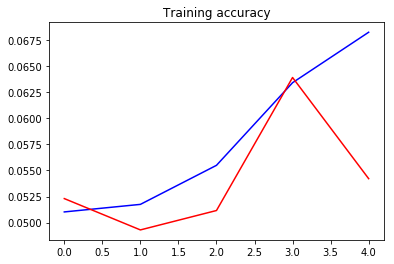

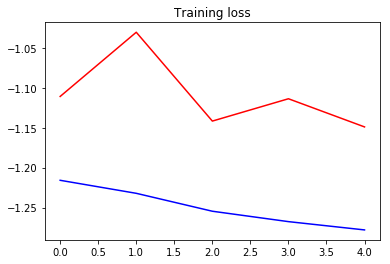

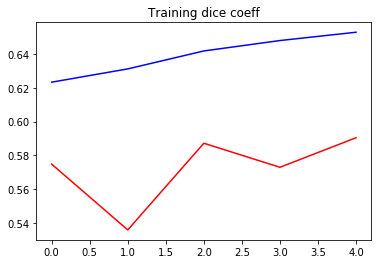

<Figure size 432x288 with 0 Axes>

In [59]:
plot_training(history)